<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/All_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloning Repo & installing libs

In [ ]:
!rm -rf education-impact

In [ ]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 480, done.
remote: Counting objects: 100% (480/480), done.
remote: Compressing objects: 100% (403/403), done.
remote: Total 480 (delta 254), reused 215 (delta 74), pack-reused 0
Receiving objects: 100% (480/480), 6.77 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (254/254), done.


In [ ]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

     |████████████████████████████████| 17.7 MB 752 kB/s 


In [ ]:
import pandas as pd
import os
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

# Setting paths

In [ ]:
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions_percapita"         :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv",
                    "20-24-In_Primary_OL_comp"        :  root+ "In_Primary_OL_complete.csv",
                    "20-24-Primary_OL_comp"           :  root+ "Primary_OL_complete.csv",
                    "20-24-Lower_Secondary_OL_comp"   :  root+ "Lower_Secondary_OL_complete.csv",
                }

created_datasets = []

# Defining common functions

In [ ]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [ ]:
def find_common_countries(datasets,o_dataset=None):
  common_countries = set()
  first_time = True
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if first_time:
      common_countries = countries_list
      first_time = False
    else:
      common_countries = common_countries.intersection(countries_list)
  if o_dataset !=None:
    countries_list = list(pd.read_csv(datasets_path[o_dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [ ]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [ ]:
def load_datasets_to_pd(datasets,keys,include_output=True,o_dataset=None):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    print("loading " + dataset)
    combined_df = add_dataset(combined_df,dataset)
    

  if o_dataset!=None:
    combined_df = add_dataset(combined_df,o_dataset,output = True)
  return combined_df

  

In [ ]:
def add_dataset(input_df,dataset,output = False):
  label = dataset
  if output : 
    label = "o_"+OUTPUT
  input_df[label] = [math.nan]*len(input_df)
  df = pd.read_csv(datasets_path[dataset])
  df["Country"] = df["Country"].str.lower()
  df.set_index("Country", inplace=True)
  for e in range(len(input_df)):
    country = input_df.iloc[e].country
    year    = input_df.iloc[e].year
  
    if output:
      input_df.at[e,label] = df.loc[country][str( int(year) + PREDICT_FUTURE )]
    else:
      input_df.at[e,label] = df.loc[country][year]
    
  return input_df

In [ ]:
def create_n_yrs_old_csv(dataset,n):
    table_name = str(n)+"_yrs_old_"+dataset
    # if table_name in created_datasets:
    #   return table_name
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1960, 2016))
    countries = list(df['Country'])
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in range(1960,2016):
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    df.set_index('Country',inplace=True)
    for c in countries:
      for y in range(1960+n,2016):
        new_df[y].at[c] = df.loc[c][str(y-n)]
    
    
    datasets_path[table_name] = root+table_name+".csv"
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [ ]:
def create_n_dropout_csv(dataset,n,s_n = 90):
    df = pd.read_csv(datasets_path[dataset])
    years = list(range(1875, 2016))
    countries = list(df['Country'])
    drop_out_years = []
    for i in range(len(df)):
      started = False
      s_year  = 1875
      for year in years:
        if not started and df.iloc[i][str(year)] < s_n :
          started = True
          s_year  = year
        elif started and df.iloc[i][str(year)] < n :
          drop_out_years.append((df.iloc[i]['Country'],(year-s_year)))
          break
      else:
        if started:
          drop_out_years.append((df.iloc[i]['Country'], 100))
        else:
          drop_out_years.append((df.iloc[i]['Country'], year-s_year))
    new_df = pd.DataFrame(countries,columns=['Country'])
    for i in years:
      new_df[i] = np.nan
    new_df.set_index('Country',inplace=True)
    for c,y in drop_out_years:
      for i in years:
        new_df.at[c,i] = y
    table_name = str(n)+"%_dropout_"+dataset
    datasets_path[table_name] = root+table_name+".csv"
    new_df = new_df[(new_df.T != 1).any()]
    new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

    created_datasets.append(table_name)
    return table_name

In [ ]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

In [ ]:
def extract_variable_imp(variable):
  v_list = inspector.variable_importances()[variable]
  v = variable + "\n"

  for i in range(0,len(v_list)):
    if v_list[0][0]!='_':
      v += str(i)+ "  "
      v += f"{v_list[i][0][0]:<50}" 
      v += str(v_list[i][1]) + "\n"
  return v

In [ ]:
def rate_of_dropout(dataset,n):
  table_name = str(n)+"_yr_period_rate_of_change_of_"+dataset

  years  = [y for y in range(1960,2016)]
  edu_df = pd.read_csv(datasets_path[dataset])
  countries = list(edu_df['Country'])
  new_df = pd.DataFrame(countries,columns=['Country'])
  for i in years:
    new_df[i] = np.nan
  new_df.set_index('Country',inplace=True)
  edu_df.set_index('Country',inplace=True)
  for c in countries:
    for y in range(1960+n,2016):
      new_df[y].at[c] = (edu_df.loc[c][str(y-n)] - edu_df.loc[c][str(y)])/n

  datasets_path[table_name] = root+table_name+".csv"
  
  new_df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)

  created_datasets.append(table_name)
  return table_name




In [ ]:
def finish_edu(dataset):
  df = pd.read_csv(datasets_path[dataset])
  names = {
            "20-24-In_Primary_OL" : "20-24-Primary_fin",
            "20-24-Primary_OL"     : "20-24-Lower_Secondary_fin",
           "20-24-Lower_Secondary_OL" : "20-24-Higher_Secondary_fin",
           "20-24_female-In_Primary_OL" : "20-24-female_Primary_fin",
            "20-24_female-Primary_OL"     : "20-24-female_Lower_Secondary_fin",
           "20-24_female-Lower_Secondary_OL" : "20-24-female_Higher_Secondary_fin"
      
          }
  # read csv 
    # atleast primary = 100 - in_primary_ol
    # atleast lower secondary = 100 - primary_ol
    # atleast higer secondary = 100 - lowersecondary_ol
  # if female:
  #   df.drop(df.columns[0], axis=1)
  df.set_index(["Country"], inplace=True)
  df.apply(pd.to_numeric)
  df = df.sub(100)
  df = df.mul(-1)
  table_name = names[dataset]
  print(table_name)
  df.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
  datasets_path[table_name] = root+table_name+".csv"
  return table_name
  

In [ ]:
edu_list = ["20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
             "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            ]

for i in edu_list:
  finish_edu(i)

20-24-Primary_fin
20-24-Lower_Secondary_fin
20-24-Higher_Secondary_fin
20-24-female_Primary_fin
20-24-female_Lower_Secondary_fin
20-24-female_Higher_Secondary_fin


# Plotting Data

In [ ]:
datasets_to_plot = [
            "life_expectancy",
            "infant_mortality",
            "child_mortality",

            "children_per_woman",

            "20-24-Primary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-Higher_Secondary_fin",

            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "gdp_growth",
            
            "population",
            

            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2016)]
keys        = generate_indices(countries, years)

combined_df_comp = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

loading life_expectancy
loading infant_mortality
loading child_mortality
loading children_per_woman
loading 20-24-Primary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-Higher_Secondary_fin
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading gdp_growth
loading population


In [ ]:
combined_df_comp.describe()

,life_expectancy,infant_mortality,child_mortality,children_per_woman,20-24-Primary_fin,20-24-Lower_Secondary_fin,20-24-Higher_Secondary_fin,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,gdp_growth,population
count,9856.000000,8955.000000,9856.000000,9856.000000,9856.000000,9856.000000,9856.000000,9676.000000,9856.000000,7685.000000,9848.000000,9.856000e+03
mean,64.719734,54.513255,87.541769,4.161540,71.389712,57.170272,35.871966,4.448684,39.678155,9056.120494,2.061148,2.860715e+07
std,10.086496,47.024194,83.890440,2.046004,30.973840,34.189538,31.199226,7.331387,9.833643,14068.705259,6.698984,1.104936e+08
min,9.500000,1.800000,2.180000,1.120000,0.100000,-0.000000,-0.100000,0.000000,16.000000,124.000000,-67.500000,4.120000e+04
25%,57.100000,15.600000,20.400000,2.210000,46.090000,25.100000,6.700000,0.364500,32.500000,1170.000000,-0.169000,1.690000e+06
50%,66.900000,41.000000,57.500000,3.900000,84.610000,57.810000,27.800000,1.640000,39.900000,3170.000000,2.140000,5.490000e+06
75%,72.400000,83.850000,134.000000,6.110000,98.980000,94.005000,61.655000,6.270000,45.100000,9450.000000,4.460000,1.660000e+07
max,84.300000,279.700000,423.000000,8.870000,100.000000,100.000000,100.000000,101.000000,77.000000,112000.000000,145.000000,1.410000e+09


In [ ]:
combined_df = combined_df_comp[(combined_df_comp.gdppercapita_us_infla_adjust<10000) & (combined_df_comp.gdp_growth>-15) &(combined_df_comp.co2_emissions_percapita<5.0)&(combined_df_comp.population<1.660000e+07)& (combined_df_comp.gdp_growth<15)  ]
combined_df = combined_df.sample(frac = 0.15, random_state=43)
combined_df.shape

(543, 14)

## Life Expectancy

ValueError: ignored

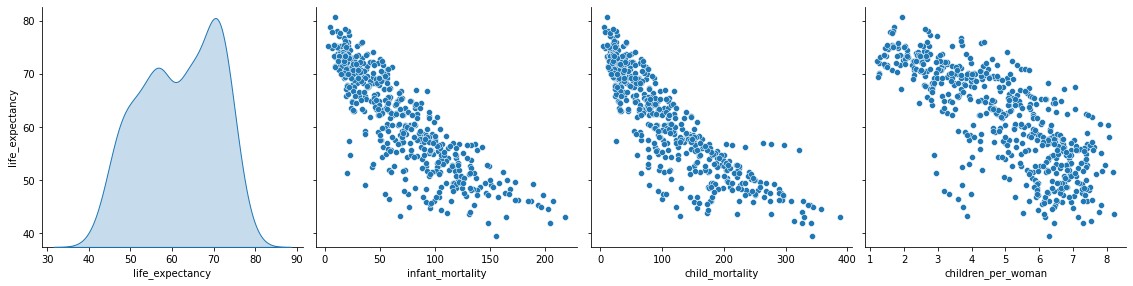

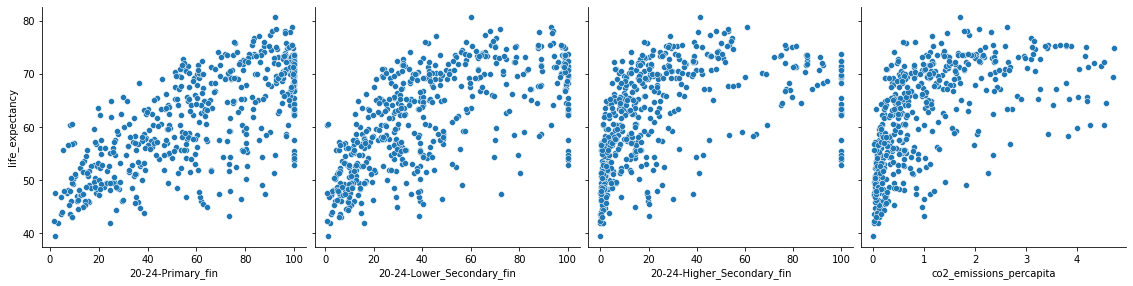

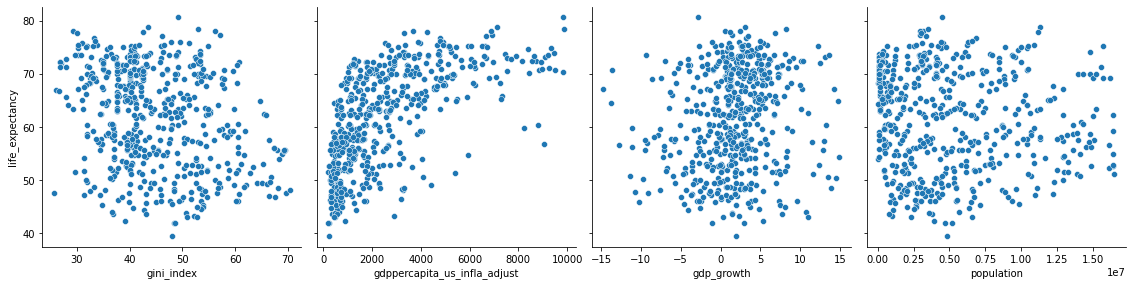

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'life_expectancy'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Total Fertility Rate

ValueError: ignored

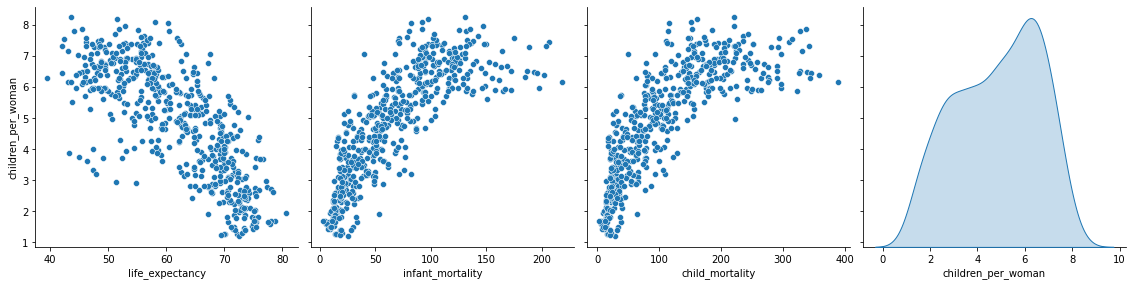

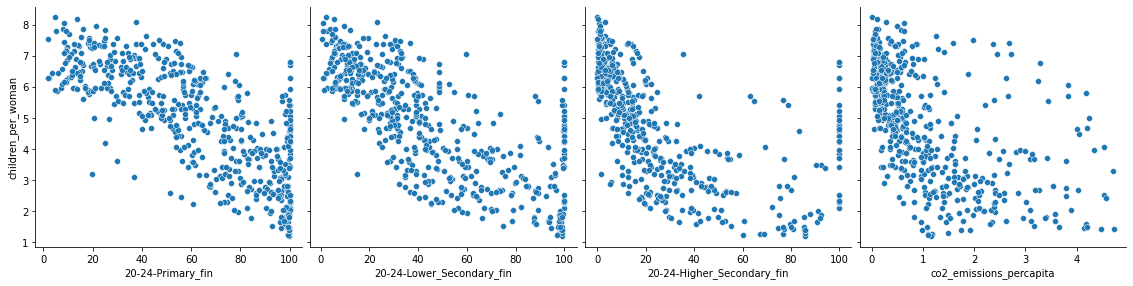

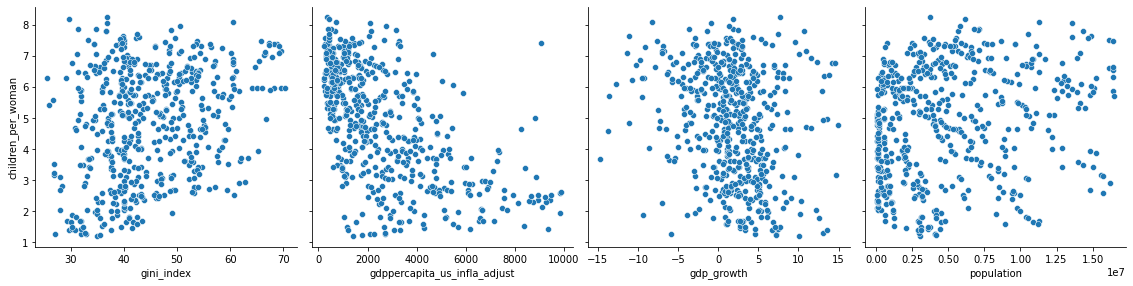

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'children_per_woman'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Primary education OL

ValueError: ignored

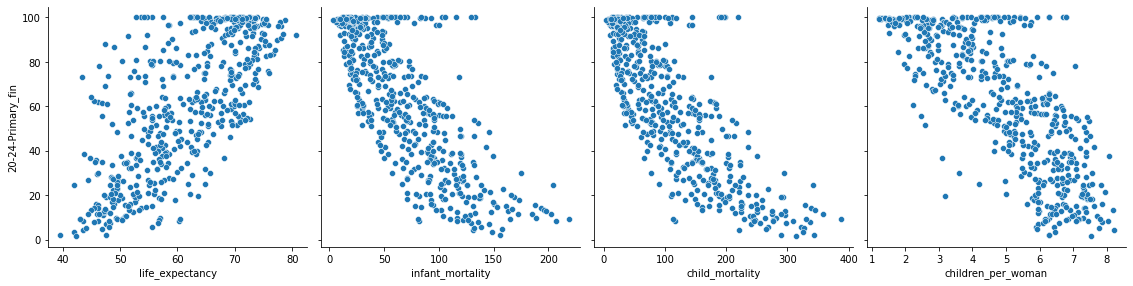

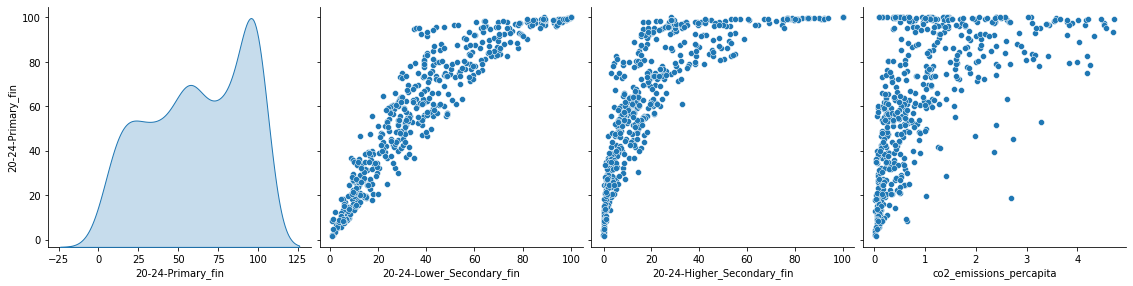

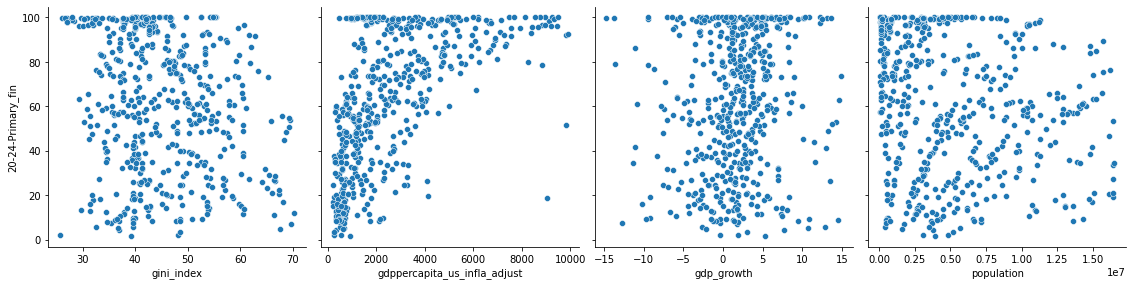

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Primary_fin'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## Lower Secondary Education education OL

ValueError: ignored

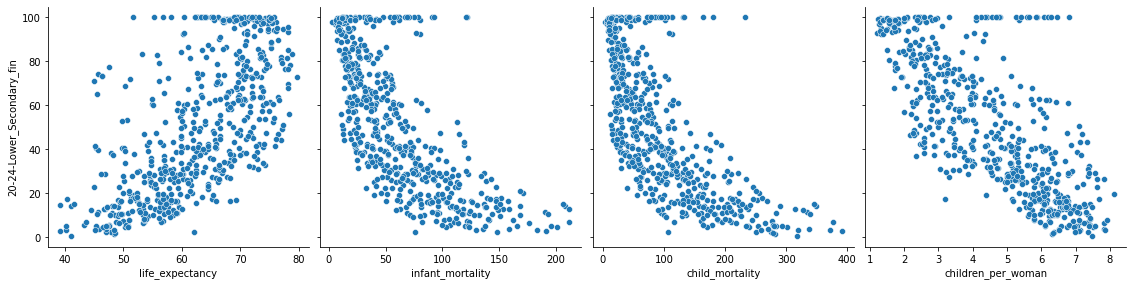

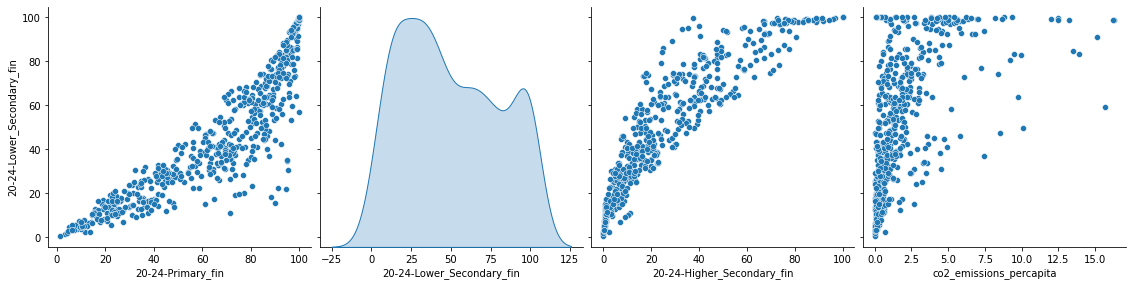

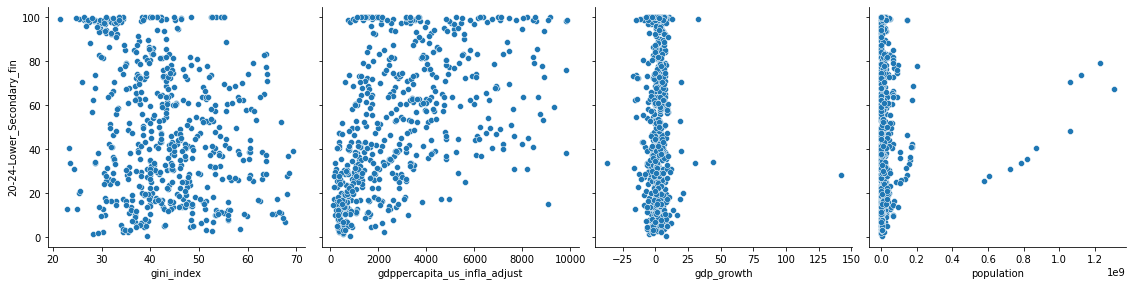

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Lower_Secondary_fin'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## GDP per capita

ValueError: ignored

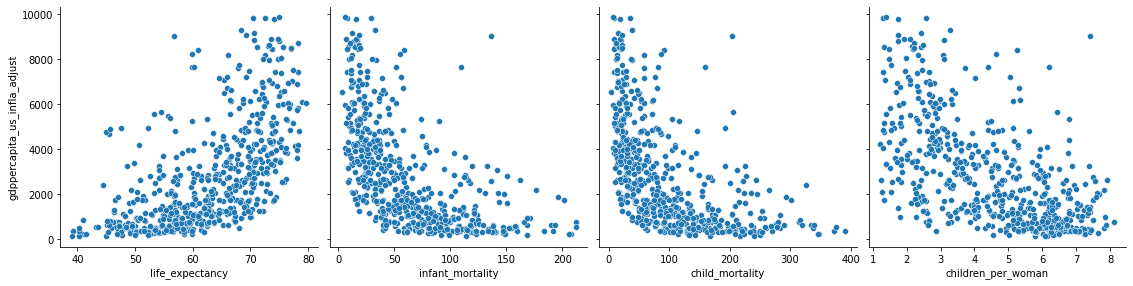

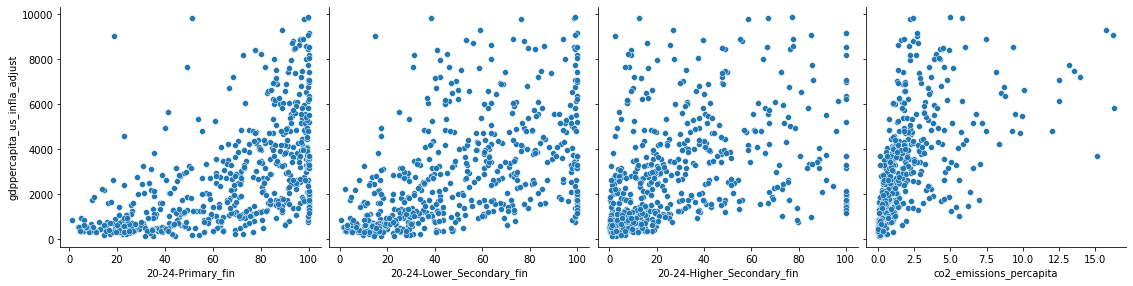

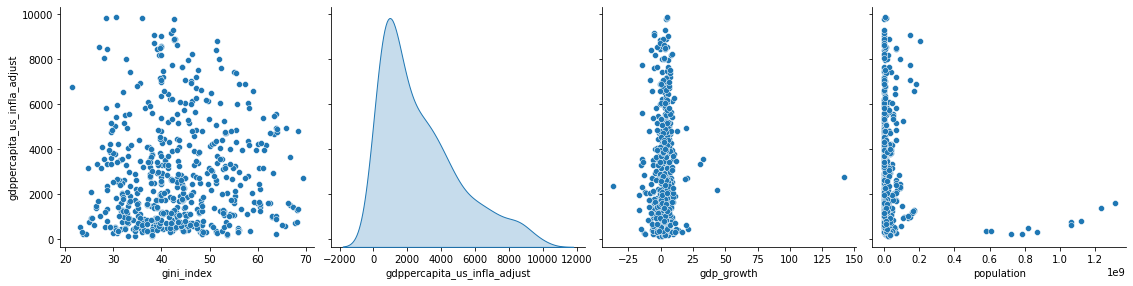

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'gdppercapita_us_infla_adjust'
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,diag_kind="kde", y_vars=[OUTPUT], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

## 3D PLOT

### LE vs Edu vs GDP

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
combined_df_na = combined_df.dropna(subset=['gdppercapita_us_infla_adjust'])
x = combined_df_na['life_expectancy'].to_numpy()
y = combined_df_na['20-24-Primary_fin'].to_numpy()
z = combined_df_na['gdppercapita_us_infla_adjust'].to_numpy()

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)

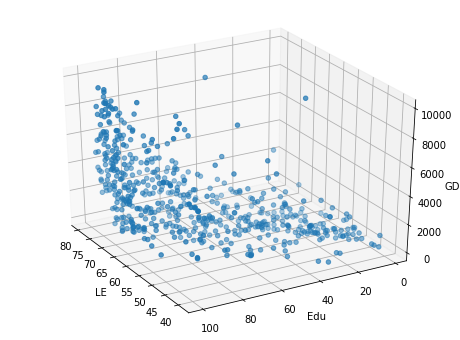

In [ ]:
ax = plt.axes(projection="3d")
ax.scatter3D(x,y,z)

ax.set_xlabel('LE')
ax.set_ylabel('Edu')
ax.set_zlabel('GDP')

ax.view_init(30,150)

# Selecting Countries

In [ ]:
datasets_sc = [
            
            "life_expectancy",
            "20-24-Primary_fin",
            "20-24-Lower_Secondary_fin",
            "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "population",
            "20-24-Higher_Secondary_fin",
            "child_mortality",
            "infant_mortality",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",
            ]

In [ ]:
countries = find_common_countries(datasets_sc,o_dataset = OUTPUT)
years     = [y for y in range(1960,2016)]
keys      = generate_indices(countries, years)

In [ ]:
input_df_sc           = load_datasets_to_pd(datasets = datasets_sc, keys = keys)

loading life_expectancy
loading 20-24-Primary_fin
loading 20-24-Lower_Secondary_fin
loading children_per_woman
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading population
loading 20-24-Higher_Secondary_fin
loading child_mortality
loading infant_mortality
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
input_1960 = input_df_sc[input_df_sc.year=='1960']
input_1960.describe()

,life_expectancy,20-24-Primary_fin,20-24-Lower_Secondary_fin,children_per_woman,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,population,20-24-Higher_Secondary_fin,child_mortality,infant_mortality,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
count,176.000000,176.000000,176.000000,176.000000,165.000000,176.000000,85.000000,1.760000e+02,176.000000,176.000000,106.000000,176.000000,176.000000,176.000000
mean,56.495455,52.382955,35.622727,5.488693,2.413272,40.692045,4188.494118,1.697994e+07,18.063636,167.782386,99.384906,48.178977,32.309659,16.361932
std,10.882756,36.995489,33.648831,1.775665,4.462762,10.969435,5757.043633,6.299490e+07,26.572311,106.360825,55.985926,39.230603,34.370763,26.134880
min,27.500000,0.100000,-0.000000,1.910000,0.007980,19.300000,131.000000,4.120000e+04,-0.100000,19.600000,16.300000,-0.000000,-0.000000,-0.100000
25%,46.900000,16.975000,6.925000,3.840000,0.160000,32.925000,768.000000,9.122500e+05,0.475000,75.175000,56.050000,8.650000,3.225000,0.100000
50%,57.200000,44.850000,23.100000,6.250000,0.677000,40.000000,1670.000000,3.440000e+06,3.400000,150.500000,103.800000,38.500000,16.950000,2.300000
75%,65.350000,95.125000,63.000000,6.885000,3.040000,46.100000,3740.000000,9.275000e+06,28.550000,253.000000,138.625000,94.050000,57.500000,24.325000
max,73.500000,100.000000,100.000000,8.190000,36.600000,77.000000,25500.000000,6.600000e+08,100.000000,423.000000,221.200000,100.000000,100.000000,100.000000


In [ ]:
# bottom 50% countries in all aspects 
poor_gdp      = input_df_sc["gdppercapita_us_infla_adjust"]<1670
poor_edu      = input_df_sc["20-24-Primary_fin"]<44.8
poor_sec_edu  = input_df_sc["20-24-Lower_Secondary_fin"]<23.1
poor_tfr = input_df_sc.children_per_woman > 5
poor_lex = input_df_sc.life_expectancy <60
input_poor_countries = input_df_sc[poor_lex & poor_tfr & poor_sec_edu & (input_df_sc['year']=='1960')]
input_poor_countries

,country,year,life_expectancy,20-24-Primary_fin,20-24-Lower_Secondary_fin,children_per_woman,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,population,20-24-Higher_Secondary_fin,child_mortality,infant_mortality,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
6,benin,1960,44.8,9.3,3.4,6.28,0.0664,35.9,679.0,2430000.0,0.1,311.0,185.0,5.2,1.8,-0.0
11,mali,1960,37.7,3.3,1.6,6.97,0.0230,53.9,NaN,5260000.0,-0.0,423.0,NaN,1.7,0.7,-0.0
12,morocco,1960,46.7,6.1,2.8,7.04,0.2950,45.8,NaN,12300000.0,0.1,237.0,144.5,1.5,0.8,-0.0
16,vanuatu,1960,51.4,21.1,9.1,7.20,NaN,37.6,NaN,63700.0,0.8,154.0,105.5,13.7,5.5,0.3
19,algeria,1960,52.4,18.3,10.1,7.52,0.5570,39.7,2170.0,11100000.0,0.3,243.0,145.5,8.1,4.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,bahrain,1960,57.3,18.7,13.8,7.09,3.5400,40.0,NaN,162000.0,2.4,199.0,133.4,10.9,8.1,1.2
170,south sudan,1960,48.6,8.9,0.2,6.69,0.0399,45.0,NaN,2840000.0,0.2,357.0,NaN,6.2,0.1,0.1
171,afghanistan,1960,45.0,7.5,0.1,7.45,0.0460,34.4,NaN,9000000.0,0.1,357.0,NaN,1.6,0.1,0.1
172,colombia,1960,59.3,40.7,14.2,6.81,1.0200,62.3,1910.0,16100000.0,2.2,136.0,94.3,40.5,13.5,2.0


In [ ]:
poor_countries_list = list(input_poor_countries.country)
poor_countries_list.sort()
print(poor_countries_list)

['afghanistan', 'algeria', 'angola', 'bahrain', 'bangladesh', 'benin', 'bhutan', 'botswana', 'brazil', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'central african republic', 'chad', 'colombia', 'comoros', 'congo, dem. rep.', 'congo, rep.', "cote d'ivoire", 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eswatini', 'ethiopia', 'gambia', 'guatemala', 'guinea', 'guinea-bissau', 'haiti', 'honduras', 'india', 'indonesia', 'iran', 'kenya', 'kiribati', 'lesotho', 'liberia', 'madagascar', 'malawi', 'maldives', 'mali', 'mauritius', 'mexico', 'morocco', 'mozambique', 'myanmar', 'namibia', 'nepal', 'nicaragua', 'niger', 'nigeria', 'oman', 'pakistan', 'rwanda', 'sao tome and principe', 'saudi arabia', 'senegal', 'sierra leone', 'solomon islands', 'somalia', 'south sudan', 'st. lucia', 'sudan', 'tanzania', 'timor-leste', 'togo', 'tunisia', 'turkey', 'uganda', 'vanuatu', 'vietnam', 'yemen', 'zambia']


# Building Model

## Life Expectancy

### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = 'life_expectancy'

In [ ]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-Lower_Secondary_OL",
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",
            ]
get_countries_count(datasets)

Factor: child_mortality                  count: 197
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: population                       count: 197
Factor: 20-24-Primary_fin                count: 202
Factor: 20-24-Higher_Secondary_fin       count: 202
Factor: 20-24-Lower_Secondary_fin        count: 202
Factor: 20-24-female_Primary_fin         count: 202
Factor: 20-24-female_Lower_Secondary_fin count: 202
Factor: 20-24-female_Higher_Secondary_fin count: 202


In [ ]:
# creating a list of all countries & years
countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)

loading child_mortality
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading population
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df.sample(n=5)

,,life_expectancy,20-24-Primary_fin,20-24-Lower_Secondary_fin,children_per_woman,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,population,20-24-Higher_Secondary_fin,child_mortality,infant_mortality,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
country,year,,,,,,,,,,,,,,
kiribati,1981,54.7,66.74,37.46,5.05,0.488,37.0,1880.0,60100.0,15.60,120.0,85.0,61.08,33.92,11.20
turkey,1966,54.1,64.72,17.40,5.93,0.994,50.3,3050.0,31700000.0,4.62,212.0,141.8,48.04,10.18,2.00
tunisia,2008,75.9,94.92,84.68,2.06,2.340,37.0,3560.0,10400000.0,37.92,19.4,16.6,92.48,82.16,40.54
gambia,1984,59.4,16.30,13.16,6.25,0.237,39.6,790.0,726000.0,1.42,205.0,95.5,6.46,4.66,0.20
south sudan,2011,60.5,33.62,17.66,5.29,0.133,45.3,2170.0,9830000.0,17.66,104.0,65.6,23.94,11.52,11.52


In [ ]:
output_df

In [ ]:
input_df.isna().sum()

In [ ]:
input_df.shape

(10024, 13)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpes2gifh0 as temporary training directory
Starting reading the dataset
1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.280992
Training model
Model trained in 0:00:04.214451
Compiling model
5/5 [==============================] - 5s 1s/step


Evaluation(num_examples=4200, accuracy=None, loss=None, rmse=0.25519299407649076, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=120)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_gdppercapita_us_infla_adjust
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.276739 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  8.833398 ###########
    3.            "gdppercapita_us_infla_adjust"  8.424226 ##########
    4.                       "20-24-Primary_fin"  8.352908 #

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpf_oa7ehs as temporary training directory
Starting reading the dataset
 9/11 [=======================>......] - ETA: 0s
Dataset read in 0:00:00.391252
Training model
Model trained in 0:00:09.457981
Compiling model
11/11 [==============================] - 10s 962ms/step


Evaluation(num_examples=None, accuracy=None, loss=1.7352077960968018, rmse=1.7352077960968018, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_gdppercapita_us_infla_adjust
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.791800 ################
    2.        "20-24-female_Lower_Secondary_fin"  4.188496 ##########
    3.              "20-24-Higher_Secondary_fin"  4.146540 ##########
    4.               "20-24-Lower_Second

## Total Fertility Rate

### Preparing the data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = 'children_per_woman'

In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("children_per_woman",n = 20),
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",

            # "population",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-Primary_fin                count: 202
Factor: 20-24-Higher_Secondary_fin       count: 202
Factor: 20-24-Lower_Secondary_fin        count: 202
Factor: 20-24-female_Primary_fin         count: 202
Factor: 20-24-female_Lower_Secondary_fin count: 202
Factor: 20-24-female_Higher_Secondary_fin count: 202


In [ ]:
# creating a list of all countries & years
countries = find_common_countries(datasets=datasets,o_dataset=OUTPUT)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin


In [ ]:
input_df

,,life_expectancy,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20-24-Primary_fin,20-24-Higher_Secondary_fin,20-24-Lower_Secondary_fin,20-24-female_Primary_fin,20-24-female_Lower_Secondary_fin,20-24-female_Higher_Secondary_fin
country,year,,,,,,,,,,
afghanistan,1960,45.0,0.0460,34.4,NaN,7.5,0.1,0.1,1.6,0.1,0.1
algeria,1960,52.4,0.5570,39.7,2170.0,18.3,0.3,10.1,8.1,4.1,0.1
angola,1960,46.3,0.1010,55.8,NaN,9.0,-0.0,2.1,3.2,1.3,0.1
bahrain,1960,57.3,3.5400,40.0,NaN,18.7,2.4,13.8,10.9,8.1,1.2
bangladesh,1960,43.8,0.0461,24.9,463.0,22.5,1.1,11.4,10.6,2.9,0.1
...,...,...,...,...,...,...,...,...,...,...,...
uganda,2015,63.9,0.1330,41.9,844.0,63.0,13.5,27.8,61.1,26.4,12.0
vanuatu,2015,65.0,0.4870,37.6,2700.0,76.6,26.1,49.7,77.3,50.0,25.7
vietnam,2015,73.9,1.9500,35.1,2090.0,93.4,36.4,74.3,93.4,76.1,37.9


In [ ]:
output_df

,,o_children_per_woman
country,year,
afghanistan,1960,7.45
algeria,1960,7.52
angola,1960,7.48
bahrain,1960,7.09
bangladesh,1960,6.73
...,...,...
uganda,2015,5.68
vanuatu,2015,3.31
vietnam,2015,1.96


In [ ]:
input_df.isna().sum()

life_expectancy                        0
co2_emissions_percapita              145
gini_index                             0
gdppercapita_us_infla_adjust         767
20-24-Primary_fin                      0
20-24-Higher_Secondary_fin             0
20-24-Lower_Secondary_fin              0
20-24-female_Primary_fin               0
20-24-female_Lower_Secondary_fin       0
20-24-female_Higher_Secondary_fin      0
dtype: int64

In [ ]:
input_df.shape

(10024, 11)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### Random Forest

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpbnujguwr as temporary training directory
Starting reading the dataset
1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.262548
Training model
Model trained in 0:00:04.190628
Compiling model
5/5 [==============================] - 5s 1s/step


Evaluation(num_examples=4200, accuracy=None, loss=None, rmse=0.24551078077966637, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=90)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_gdppercapita_us_infla_adjust
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.222562 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  8.653449 ###########
    3.                       "20-24-Primary_fin"  8.254203 ##########
    4.            "gdppercapita_us_infla_adjust"  8.230791 ##########
    5.                 "c

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpkm6ogv74 as temporary training directory
Starting reading the dataset
1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.264291
Training model
Model trained in 0:00:04.285687
Compiling model
5/5 [==============================] - 5s 1s/step


Evaluation(num_examples=None, accuracy=None, loss=0.1862088292837143, rmse=0.1862088292837143, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
input_df.drop(columns=['20-24-female_Higher_Secondary_fin'],inplace=True)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_gdppercapita_us_infla_adjust
	child_mortality
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.731465 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  4.113517 #########
    3.                       "20-24-Primary_fin"  3.963216 ########
    4.              "20-24-Higher_Secondary_fin"  3.949225 ########
    5.       

## Primary education Completion

### Preparing the data

In [ ]:
PREDICT_FUTURE = 0
OUTPUT         = '20-24-Primary_fin'


In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "gini_index",
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("gini_index",n = 20),
            "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 10),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("infant_mortality",n = 20),
            
            "co2_emissions_percapita",
            create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            create_n_yrs_old_csv("co2_emissions_percapita",n = 20),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            
            # "20-24-Primary_fin",
            # "20-24-Lower_Secondary_fin",
            

            create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            "population",
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: gini_index                       count: 195
Factor: 10_yrs_old_gini_index            count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 10_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: co2_emissions_percapita          count: 194
Factor: 10_yrs_old_co2_emissions_percapita count: 194
Factor: 20_yrs_old_co2_emissions_percapita count: 194
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 20_yrs_old_20-24-Primary_fin     count: 202
Factor: 20_yrs_old_20-24-Lower_Secondary_fin count: 202
Factor: 20_yrs_old_20-24-Higher_Secondary_fin count: 202
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.dropna(subset=["gdppercapita_us_infla_adjust"],inplace=True)
# input_df.set_index(["country","year"], inplace=True)
# output_df           = input_df[["o_" + OUTPUT]]
# input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)


loading life_expectancy
loading gini_index
loading 10_yrs_old_gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading co2_emissions_percapita
loading 10_yrs_old_co2_emissions_percapita
loading 20_yrs_old_co2_emissions_percapita
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading 20_yrs_old_20-24-Primary_fin
loading 20_yrs_old_20-24-Lower_Secondary_fin
loading 20_yrs_old_20-24-Higher_Secondary_fin
loading population


In [ ]:
input_df

,country,year,life_expectancy,gini_index,gdppercapita_us_infla_adjust,co2_emissions_percapita,10_yrs_old_co2_emissions_percapita,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,20_yrs_old_20-24-Primary_fin,20_yrs_old_20-24-Lower_Secondary_fin,20_yrs_old_20-24-Higher_Secondary_fin,population,o_20-24-Primary_fin
0,canada,1960,71.2,33.0,NaN,10.8000,NaN,NaN,NaN,NaN,NaN,NaN,17800000.0,95.7
1,papua new guinea,1960,53.7,52.6,1160.0,0.0796,NaN,NaN,NaN,NaN,NaN,NaN,2260000.0,100.0
2,kazakhstan,1960,61.4,37.7,NaN,9.3900,NaN,NaN,NaN,NaN,NaN,NaN,9930000.0,90.2
3,lithuania,1960,69.9,29.1,NaN,4.5000,NaN,NaN,NaN,NaN,NaN,NaN,2770000.0,96.1
4,bolivia,1960,43.0,45.1,1290.0,0.2750,NaN,NaN,NaN,NaN,NaN,NaN,3660000.0,38.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10019,afghanistan,2015,61.9,36.8,578.0,0.2620,0.0515,151.00,7.61,20.1,3.7,3.7,34400000.0,57.0
10020,colombia,2015,79.7,51.7,6180.0,1.9600,1.4100,29.70,2.66,80.4,51.2,37.4,47500000.0,92.1
10021,comoros,2015,67.5,45.5,1240.0,0.2170,0.2280,108.00,5.25,49.0,29.5,7.2,777000.0,79.5
10022,slovenia,2015,81.0,25.6,20900.0,6.5800,8.5000,7.44,1.27,99.8,98.9,79.4,2069999.0,99.9


In [ ]:
input_df.isna().sum()

country                                     0
year                                        0
life_expectancy                             0
gini_index                                  0
gdppercapita_us_infla_adjust             2229
co2_emissions_percapita                   180
10_yrs_old_co2_emissions_percapita       1970
20_yrs_old_child_mortality               3580
20_yrs_old_children_per_woman            3580
20_yrs_old_20-24-Primary_fin             3580
20_yrs_old_20-24-Lower_Secondary_fin     3580
20_yrs_old_20-24-Higher_Secondary_fin    3580
population                                  0
o_20-24-Primary_fin                         0
dtype: int64

In [ ]:
input_df.shape

(4200, 18)

In [ ]:
for i in range(1,input_df.shape[1]+1):
  print(f"{i} => {input_df.dropna(thresh=i).shape}")


1 => (4200, 18)
2 => (4200, 18)
3 => (4200, 18)
4 => (4200, 18)
5 => (4200, 18)
6 => (4200, 18)
7 => (4151, 18)
8 => (3837, 18)
9 => (3408, 18)
10 => (3189, 18)
11 => (3108, 18)
12 => (2700, 18)
13 => (2680, 18)
14 => (2667, 18)
15 => (2648, 18)
16 => (2443, 18)
17 => (2218, 18)
18 => (1928, 18)


In [ ]:
input_df.dropna().shape

(5734, 14)

In [ ]:
output_df

,,o_20-24-Primary_fin
country,year,
canada,1960,95.7
papua new guinea,1960,100.0
kazakhstan,1960,90.2
lithuania,1960,96.1
bolivia,1960,38.6
...,...,...
afghanistan,2015,57.0
colombia,2015,92.1
comoros,2015,79.5


In [ ]:
output_df.describe()

,o_20-24-Primary_OL
count,6336.000000
mean,36.062421
std,31.821941
min,0.000000
25%,3.760000
50%,31.140000
75%,63.705000
max,100.000000


### to plot country

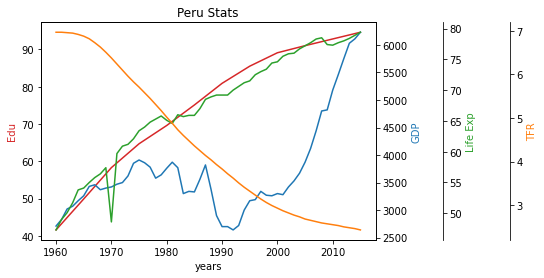

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])

  fig, ax = plt.subplots()
  ax.set_xlabel('years')
  ax.set_ylabel("Edu", color="tab:red")
  # ax.ylim([0,100])
  twin1 = ax.twinx()
  color = 'tab:blue'
  twin1.set_ylabel('GDP', color=color)
  # twin1.set_ylim([0,30000])

  twin2 = ax.twinx()
  twin2.spines['right'].set_position(('axes', 1.2))
  color = 'tab:green'
  twin2.set_ylabel('Life Exp', color=color)
  # twin2.set_ylim([40,90])

  twin3 = ax.twinx()
  twin3.spines['right'].set_position(('axes', 1.4))
  color = 'tab:orange'
  twin3.set_ylabel('TFR', color=color)
  # twin3.set_ylim([0,7])


  edu_df = edu_df[edu_df.Country.isin([country])]
  gdp_df = gdp_df[gdp_df.Country.isin([country])]
  le_df  = le_df[le_df.Country.isin([country])]
  tfr_df = tfr_df[tfr_df.Country.isin([country])]
  
  y_edu = list(edu_df.values[0][1:])
  y_gdp = list(gdp_df.values[0][1:])
  y_le  = list(le_df.values[0][1:])
  y_tfr = list(tfr_df.values[0][1:])

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  twin1.plot(x, y_gdp,label="GDP", color='tab:blue')
  twin2.plot(x, y_le,label="Life Exp",color='tab:green')
  twin3.plot(x, y_tfr,label="TFR",color='tab:orange')
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.show()

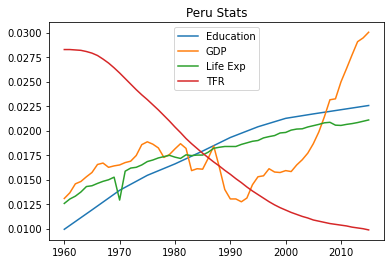

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])
  # ax.ylim([0,100])
  
  y_edu = edu_df[edu_df.Country.isin([country])]
  y_gdp = gdp_df[gdp_df.Country.isin([country])]
  y_le  = le_df[le_df.Country.isin([country])]
  y_tfr = tfr_df[tfr_df.Country.isin([country])]

  y_edu = list(y_edu.values[0][1:])
  y_gdp = list(y_gdp.values[0][1:])
  y_le  = list(y_le.values[0][1:])
  y_tfr = list(y_tfr.values[0][1:])
  
  
  y_edu = [float(i)/sum(y_edu) for i in y_edu]
  y_gdp = [float(i)/sum(y_gdp) for i in y_gdp]
  y_le = [float(i)/sum(y_le) for i in y_le]
  y_tfr = [float(i)/sum(y_tfr) for i in y_tfr]
  
  plt.plot(x, y_edu,label="Education")
  plt.plot(x, y_gdp,label="GDP")
  plt.plot(x, y_le,label="Life Exp")
  plt.plot(x, y_tfr,label="TFR")

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.legend()
  plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.3, random_state=43)

### RF

In [ ]:
for i in range(6,input_df.shape[1]+1):
  input_df_cpy = input_df.dropna(thresh=i).copy()
  input_df_cpy.set_index(["country","year"], inplace=True)
  output_df_cpy           = input_df_cpy[["o_" + OUTPUT]]
  input_df_cpy.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)
  # converting pandas to tensorFlow dataset
  train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df_cpy,output_df_cpy), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
  model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
  model.fit(x=train_ds)
  model.compile(metrics=["mse"])
  print(f"For Threshold = {i} size is {input_df_cpy.shape}")
  print(model.make_inspector().evaluation())

In [ ]:

input_df.dropna(thresh=18, inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df.index

('papua new guinea', '1980')

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
model.fit(x=train_ds)
model.compile(metrics=["mse"])

print(model.make_inspector().evaluation())

Use /tmp/tmphegdc2tr as temporary training directory
Starting reading the dataset
1/2 [==============>...............] - ETA: 0s
Dataset read in 0:00:00.235208
Training model
Model trained in 0:00:01.867049
Compiling model
2/2 [==============================] - 2s 2s/step
Evaluation(num_examples=1928, accuracy=None, loss=None, rmse=2.4861725453036168, ndcg=None, aucs=None)


In [ ]:
X_test.shape

(3008, 15)

In [ ]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_test,y_test), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
# model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

1/1 [==============================] - 0s 112ms/step - loss: 0.0000e+00 - mse: 1.6918
20-24-PRIMARY_FIN
{'loss': 0.0, 'mse': 1.691826581954956}

MSE: 1.691826581954956
RMSE: 1.300702341796522


In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (15):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_20-24-Higher_Secondary_fin
	20_yrs_old_20-24-Lower_Secondary_fin
	20_yrs_old_20-24-Primary_fin
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_co2_emissions_percapita
	20_yrs_old_gdppercapita_us_infla_adjust
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  9.576414 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  8.748289 ########

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpz6_6mb8e as temporary training directory
Starting reading the dataset
1/6 [====>.........................] - ETA: 1s
Dataset read in 0:00:00.242843
Training model
Model trained in 0:00:05.156106
Compiling model
6/6 [==============================] - 5s 1s/step


Evaluation(num_examples=None, accuracy=None, loss=3.3147332668304443, rmse=3.3147332668304443, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	10_yrs_old_co2_emissions_percapita
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_co2_emissions_percapita
	20_yrs_old_gdppercapita_us_infla_adjust
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.748442 ################
    2. "20_yrs_old_gdppercapita_us_infla_adjust"  4.049335 ########
    3.      "20_yrs_old_co2_emissions_percapita"  4.038618 ########
    4.      "10_yrs_o

In [ ]:
for f in created_datasets:
  if os.path.isfile(datasets_path[f]): # this makes the code more robust
        # os.remove(datasets_path[f])

## Lower Secondary Education Completion

### Preparing the data

In [ ]:
PREDICT_FUTURE = 0
OUTPUT         = '20-24-Lower_Secondary_fin'


In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("infant_mortality",n = 20),
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 10),
            # "20-24-Primary_fin",
            # "20-24-Lower_Secondary_fin",
            # "life_expectancy",
            # "children_per_woman",

            create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 10_yrs_old_gini_index            count: 195
Factor: 20_yrs_old_life_expectancy       count: 195
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 10_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
countries = poor_countries_list
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.dropna(subset=["gdppercapita_us_infla_adjust"],inplace=True)
input_df.set_index(["country","year"], inplace=True)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

loading life_expectancy
loading gini_index
loading gdppercapita_us_infla_adjust
loading 10_yrs_old_gini_index
loading 20_yrs_old_life_expectancy
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading 10_yrs_old_gdppercapita_us_infla_adjust
loading population


### to plot country

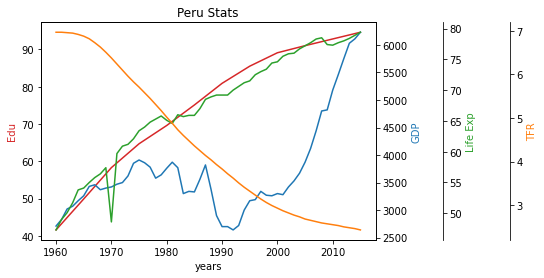

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])

  fig, ax = plt.subplots()
  ax.set_xlabel('years')
  ax.set_ylabel("Edu", color="tab:red")
  # ax.ylim([0,100])
  twin1 = ax.twinx()
  color = 'tab:blue'
  twin1.set_ylabel('GDP', color=color)
  # twin1.set_ylim([0,30000])

  twin2 = ax.twinx()
  twin2.spines['right'].set_position(('axes', 1.2))
  color = 'tab:green'
  twin2.set_ylabel('Life Exp', color=color)
  # twin2.set_ylim([40,90])

  twin3 = ax.twinx()
  twin3.spines['right'].set_position(('axes', 1.4))
  color = 'tab:orange'
  twin3.set_ylabel('TFR', color=color)
  # twin3.set_ylim([0,7])


  edu_df = edu_df[edu_df.Country.isin([country])]
  gdp_df = gdp_df[gdp_df.Country.isin([country])]
  le_df  = le_df[le_df.Country.isin([country])]
  tfr_df = tfr_df[tfr_df.Country.isin([country])]
  
  y_edu = list(edu_df.values[0][1:])
  y_gdp = list(gdp_df.values[0][1:])
  y_le  = list(le_df.values[0][1:])
  y_tfr = list(tfr_df.values[0][1:])

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  twin1.plot(x, y_gdp,label="GDP", color='tab:blue')
  twin2.plot(x, y_le,label="Life Exp",color='tab:green')
  twin3.plot(x, y_tfr,label="TFR",color='tab:orange')
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.show()

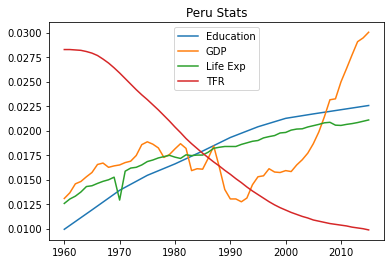

In [ ]:
import matplotlib.pyplot as plt

countries = ['Peru']

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years

for  country in countries:

  edu_df = pd.read_csv(datasets_path[edu_parameter])
  gdp_df = pd.read_csv(datasets_path[gdp_parameter])
  le_df  = pd.read_csv(datasets_path[le_parameter])
  tfr_df = pd.read_csv(datasets_path[tfr_parameter])
  # ax.ylim([0,100])
  
  y_edu = edu_df[edu_df.Country.isin([country])]
  y_gdp = gdp_df[gdp_df.Country.isin([country])]
  y_le  = le_df[le_df.Country.isin([country])]
  y_tfr = tfr_df[tfr_df.Country.isin([country])]

  y_edu = list(y_edu.values[0][1:])
  y_gdp = list(y_gdp.values[0][1:])
  y_le  = list(y_le.values[0][1:])
  y_tfr = list(y_tfr.values[0][1:])
  
  
  y_edu = [float(i)/sum(y_edu) for i in y_edu]
  y_gdp = [float(i)/sum(y_gdp) for i in y_gdp]
  y_le = [float(i)/sum(y_le) for i in y_le]
  y_tfr = [float(i)/sum(y_tfr) for i in y_tfr]
  
  plt.plot(x, y_edu,label="Education")
  plt.plot(x, y_gdp,label="GDP")
  plt.plot(x, y_le,label="Life Exp")
  plt.plot(x, y_tfr,label="TFR")

  ax.plot(x,y_edu,label="Edu",color = "tab:red")
  
  
  # giving a title to my graph
  plt.title(country + ' Stats')
  
  # function to show the plot
  plt.legend()
  plt.show()

In [ ]:
input_df

,,10_yrs_old_gini_index,10_yrs_old_co2_emissions_percapita,23_yrs_old_life_expectancy,23_yrs_old_child_mortality,23_yrs_old_children_per_woman,5_yrs_old_gdppercapita_us_infla_adjust,gdppercapita_us_infla_adjust,23_yrs_old_20-24-female_Lower_Secondary_fin,23_yrs_old_20-24-female_Higher_Secondary_fin,population
country,year,,,,,,,,,,
finland,1980,30.0,8.7600,NaN,NaN,NaN,20800.0,23900.0,NaN,NaN,4790000.0
fiji,1980,39.0,1.0000,NaN,NaN,NaN,3260.0,3630.0,NaN,NaN,635000.0
costa rica,1980,47.4,0.6760,NaN,NaN,NaN,5490.0,6210.0,NaN,NaN,2390000.0
dominican republic,1980,44.6,0.6910,NaN,NaN,NaN,2380.0,2720.0,NaN,NaN,5800000.0
panama,1980,58.0,1.4500,NaN,NaN,NaN,4770.0,5610.0,NaN,NaN,1980000.0
...,...,...,...,...,...,...,...,...,...,...,...
cambodia,2015,42.0,0.2090,58.6,117.0,5.24,891.0,1160.0,12.58,2.10,15500000.0
papua new guinea,2015,46.7,0.6750,62.7,83.9,4.72,2240.0,2680.0,100.00,100.00,8109999.0
mozambique,2015,46.6,0.0865,52.1,234.0,6.12,480.0,590.0,7.46,0.78,27000000.0


In [ ]:
input_df.isna().sum()

country                                           0
year                                              0
10_yrs_old_gini_index                             0
10_yrs_old_co2_emissions_percapita               98
23_yrs_old_life_expectancy                      537
23_yrs_old_child_mortality                      537
23_yrs_old_children_per_woman                   537
5_yrs_old_gdppercapita_us_infla_adjust          969
gdppercapita_us_infla_adjust                    639
23_yrs_old_20-24-female_Lower_Secondary_fin     537
23_yrs_old_20-24-female_Higher_Secondary_fin    537
population                                        0
dtype: int64

In [ ]:
input_df.shape

(6444, 11)

In [ ]:
output_df

,,o_20-24-Primary_OL
country,year,
turkey,1980,62.0
"micronesia, fed. sts.",1980,19.2
zambia,1980,67.2
france,1980,18.0
yemen,1980,100.0
...,...,...
ethiopia,2015,80.5
kuwait,2015,30.9
bosnia and herzegovina,2015,1.6


In [ ]:
output_df.describe()

,o_20-24-Primary_OL
count,6336.000000
mean,36.062421
std,31.821941
min,0.000000
25%,3.760000
50%,31.140000
75%,63.705000
max,100.000000


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

### RF

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp5ohvbq33 as temporary training directory
Starting reading the dataset
1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.175424
Training model
Model trained in 0:00:03.230587
Compiling model
5/5 [==============================] - 4s 993ms/step


Evaluation(num_examples=4200, accuracy=None, loss=None, rmse=4.499530180762884, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_life_expectancy
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL" 11.201451 ################
    2.                   "10_yrs_old_gini_index"  8.036847 ##########
    3.                              "gini_index"  7.963213 #########
    4. "10_yrs_old_gdppercapita_us_infla_adjust"  7.629784 #########
    5.              "20_yrs_old_life_expectancy"  5.773921 #####
    6.       

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpovboftbi as temporary training directory
Starting reading the dataset


1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.189687
Training model
Model trained in 0:00:03.267589
Compiling model
5/5 [==============================] - 3s 832ms/step


Evaluation(num_examples=None, accuracy=None, loss=4.001015663146973, rmse=4.001015663146973, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	10_yrs_old_gdppercapita_us_infla_adjust
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_life_expectancy
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.708079 ################
    2.              "20_yrs_old_life_expectancy"  4.044714 ##########
    3. "10_yrs_old_gdppercapita_us_infla_adjust"  3.974961 ##########
    4.           "20_yrs_old_children_per_woman"  3.809152 ########
    5.              "20_yrs_old_child_mortality"  3.651403 #

In [ ]:
for f in created_datasets:
  if os.path.isfile(datasets_path[f]): # this makes the code more robust
        # os.remove(datasets_path[f])

## GDP per capita

### Preparing the data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT         = 'gdppercapita_us_infla_adjust'


In [ ]:
datasets = [
            # "infant_mortality",
             "life_expectancy",
            # "child_mortality",
            "children_per_woman",
            # "co2_emissions_percapita",
            # "gini_index",
            create_n_yrs_old_csv("infant_mortality",n = 25),
            #  create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 25),
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("20-24-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_OL",n = 20),
            "20-24-Primary_fin",
            "20-24-Higher_Secondary_fin",
            "20-24-Lower_Secondary_fin",
            "20-24-female_Primary_fin",
            "20-24-female_Lower_Secondary_fin",
            "20-24-female_Higher_Secondary_fin",
            "population",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: children_per_woman               count: 202
Factor: 25_yrs_old_infant_mortality      count: 266
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 25_yrs_old_children_per_woman    count: 202
Factor: 20-24-Primary_fin                count: 202
Factor: 20-24-Higher_Secondary_fin       count: 202
Factor: 20-24-Lower_Secondary_fin        count: 202
Factor: 20-24-female_Primary_fin         count: 202
Factor: 20-24-female_Lower_Secondary_fin count: 202
Factor: 20-24-female_Higher_Secondary_fin count: 202
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
countries = poor_countries_list
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True) 
# input_df['o_gdppercapita_us_infla_adjust'] = np.log(input_df['o_gdppercapita_us_infla_adjust'])
# input_df['20_yrs_old_gdppercapita_us_infla_adjust'] = np.log(input_df['20_yrs_old_gdppercapita_us_infla_adjust'])

loading life_expectancy
loading children_per_woman
loading 25_yrs_old_infant_mortality
loading 20_yrs_old_child_mortality
loading 25_yrs_old_children_per_woman
loading 20-24-Primary_fin
loading 20-24-Higher_Secondary_fin
loading 20-24-Lower_Secondary_fin
loading 20-24-female_Primary_fin
loading 20-24-female_Lower_Secondary_fin
loading 20-24-female_Higher_Secondary_fin
loading population


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
print(input_df.shape)
input_df.isna().sum()

(6336, 6)


gini_index                                    0
20_yrs_old_infant_mortality                 901
20_yrs_old_children_per_woman                 0
20_yrs_old_gdppercapita_us_infla_adjust    2097
20_yrs_old_20-24-Lower_Secondary_OL           0
population                                    0
dtype: int64

In [ ]:
input_df.describe()

,gini_index,20_yrs_old_infant_mortality,20_yrs_old_life_expectancy,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,gdp_growth,20-24-In_Primary_OL,20-24-Primary_OL,20-24-Lower_Secondary_OL,population,20-24_female-Primary_OL
count,9856.000000,5435.000000,6336.000000,6336.000000,6336.000000,9848.000000,9856.000000,9856.000000,9856.000000,9.856000e+03,9856.000000
mean,39.678155,68.361840,62.380193,109.496630,4.723515,2.061148,28.610288,42.829728,64.128034,2.860715e+07,45.114154
std,9.833643,50.617856,9.826351,90.499713,2.020725,6.698984,30.973840,34.189538,31.199226,1.104936e+08,36.423003
min,16.000000,4.000000,9.500000,4.830000,1.210000,-67.500000,0.000000,0.000000,0.000000,4.120000e+04,0.000000
25%,32.500000,23.700000,54.600000,30.600000,2.650000,-0.169000,1.020000,5.995000,38.345000,1.690000e+06,5.815000
50%,39.900000,56.600000,64.500000,82.000000,5.130000,2.140000,15.390000,42.190000,72.200000,5.490000e+06,42.770000
75%,45.100000,105.550000,70.500000,174.000000,6.550000,4.460000,53.910000,74.900000,93.300000,1.660000e+07,81.800000
max,77.000000,279.700000,80.200000,423.000000,8.870000,145.000000,99.900000,100.000000,100.100000,1.410000e+09,100.000000


In [ ]:
input_df

,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_life_expectancy,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-In_Primary_OL,20_yrs_old_20-24-Primary_OL,20_yrs_old_20-24-Lower_Secondary_OL,20_yrs_old_20-24_female-In_Primary_OL,20_yrs_old_20-24_female-Primary_OL,gdp_growth,population
country,year,,,,,,,,,,,,,
djibouti,1980,36.5,NaN,56.2,250.00,6.46,NaN,0.0,0.0,0.0,0.0,0.0,-1.550,359000.0
nepal,1980,30.7,216.4,44.6,322.00,5.96,328.0,90.5,94.7,99.8,97.5,98.7,-4.760,15000000.0
greece,1980,37.5,39.5,72.4,46.30,2.33,5030.0,18.8,68.3,87.6,25.4,74.5,0.904,9630000.0
gambia,1980,39.6,152.5,53.9,361.00,5.57,NaN,95.9,96.8,100.0,97.3,98.0,-12.800,637000.0
denmark,1980,27.5,21.3,72.5,25.00,2.54,18100.0,0.1,0.2,71.7,0.2,0.4,-0.431,5120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
germany,2015,31.6,5.3,76.9,6.46,1.31,31600.0,0.0,3.6,25.2,0.0,3.9,1.450,81800000.0
ukraine,2015,24.8,17.3,67.0,20.30,1.41,1920.0,0.3,0.6,24.2,0.3,0.3,NaN,44900000.0
barbados,2015,43.8,13.7,73.9,15.20,1.73,14000.0,0.0,0.0,0.0,0.0,0.0,0.640,285000.0


### Random Forest

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_test,y_test), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp3q9cp2st as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.207083
Training model
Model trained in 0:00:02.375577
Compiling model
3/3 [==============================] - 3s 1s/step


Evaluation(num_examples=2497, accuracy=None, loss=None, rmse=1368.5797206817556, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300

model.summary()


Model: "random_forest_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_child_mortality
	25_yrs_old_children_per_woman
	25_yrs_old_infant_mortality
	children_per_woman
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL" 11.123372 ################
    2.       "25_yrs_old_infant_mortality"  8.921889 ###########
    3.     "25_yrs_old_children_per_woman"  7.641716 #########
    4.          "20-24-female_Primary_fin"  7.356450 #########
    5.  "20-24-

### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_test,y_test), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
# print()
model.make_inspector().evaluation()

Use /tmp/tmpehm8cqyy as temporary training directory
Starting reading the dataset
1/6 [====>.........................] - ETA: 0s
Dataset read in 0:00:00.227222
Training model
Model trained in 0:00:05.468861
Compiling model
6/6 [==============================] - 6s 1s/step


Evaluation(num_examples=None, accuracy=None, loss=3233.199462890625, rmse=3233.199462890625, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	20_yrs_old_child_mortality
	25_yrs_old_infant_mortality
	30_yrs_old_children_per_woman
	children_per_woman
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  4.694738 ################
    2.          "20-24-female_Primary_fin"  4.167693 ##########
    3. "20-24-female_Higher_Secondary_fin"  4.145658 ##########
    4.        "20-24-Higher_Secondary_fin"  4.087651 ########

# Building Model for Best Performing Countries

## Preparing DataFrames of Top Performing Countries

In [ ]:
try:
  os.mkdir(root+"best_performers")
except:
  pass

### Life Expectany

In [ ]:
le_threshold_percentile = 85
le_start_percentile = 60    # it means consider bottom 60% of countries
le_parameter = 'life_expectancy'

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4]
le_pd = pd.read_csv(datasets_path[le_parameter])
describe = le_pd.describe(percentiles = percentiles)

le_pd.reset_index(inplace=True, drop=True)
le_pd.set_index(["Country"],inplace=True)
sk_start_value = le_pd.loc['South Korea']['1960']


In [ ]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']>sk_start_value:
    start_value = describe.loc[s_index]['1960']
    break
start_value

70.4

In [ ]:
start_value = describe.loc[str(le_start_percentile)+"%"]["1960"]

In [ ]:
undeveloped_countries_pd = le_pd.loc[le_pd['1960'] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,45.0,45.3,45.5,45.7,45.9,46.1,46.3,46.5,46.7,46.9,47.1,47.3,47.3,47.3,47.4,47.5,47.7,47.9,46.4,44.7,43.7,44.3,44.1,42.3,39.9,42.0,43.3,45.9,48.5,52.7,53.8,53.8,54.2,54.4,53.9,54.3,54.7,54.5,53.3,54.7,54.7,54.8,55.5,56.5,57.1,57.6,58.0,58.5,59.2,59.9,60.5,61.0,61.4,61.9,61.9,61.9
Angola,46.3,44.8,45.0,45.2,45.4,45.6,45.8,46.0,46.2,46.4,46.6,46.8,47.0,47.2,47.4,47.5,47.5,47.7,47.8,48.0,48.1,48.2,48.2,48.2,48.4,48.6,48.6,48.6,48.6,49.4,49.7,50.3,50.3,49.0,50.3,51.2,51.7,51.6,50.6,51.9,52.8,53.4,54.5,55.1,55.5,56.4,57.0,58.0,58.8,59.5,60.2,60.8,61.4,62.1,63.0,63.5
United Arab Emirates,60.3,60.8,61.3,61.6,62.1,62.6,63.0,63.4,63.8,64.2,64.0,64.9,65.1,65.4,65.7,66.0,66.3,66.6,67.0,67.3,67.6,68.0,68.1,67.9,68.4,68.5,68.5,68.5,68.5,68.6,68.7,68.7,68.8,68.8,68.7,68.8,68.9,69.0,69.2,69.2,69.1,69.2,69.4,69.3,69.1,69.2,69.5,70.0,70.4,70.6,70.8,71.0,71.2,71.6,73.0,73.2
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Azerbaijan,48.6,50.2,51.7,53.1,54.4,55.6,56.6,57.5,58.2,58.4,59.9,61.0,61.9,62.8,63.7,64.3,65.2,65.3,64.8,65.6,66.2,66.3,66.6,66.8,66.8,66.9,66.9,66.8,66.8,67.0,66.9,66.3,64.5,64.3,63.8,64.7,65.3,65.7,66.0,66.2,66.5,67.1,67.2,67.1,67.2,67.3,67.7,68.2,68.5,68.8,69.0,69.2,69.5,69.7,69.9,70.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,60.7,61.1,61.3,61.4,57.2,61.3,61.3,61.8,62.0,62.2,62.4,62.6,63.0,63.2,63.3,63.6,64.1,64.4,64.7,65.0,65.2,65.4,65.5,65.7,65.8,66.0,66.2,66.4,66.6,66.8,66.9,66.9,67.2,67.4,67.5,67.7,67.8,68.0,68.2,68.3,68.5,68.6,68.8,68.9,69.0,69.0,69.2,69.3,69.5,67.5,69.6,69.7,69.6,69.9,70.0,70.1
Yemen,36.5,37.1,36.3,36.9,37.6,38.2,38.8,39.4,40.2,41.0,41.9,44.3,45.4,46.6,47.6,48.7,49.8,50.9,51.8,52.6,53.3,54.0,54.3,55.5,56.1,56.7,55.2,57.7,58.2,58.6,59.1,59.5,59.9,60.3,60.5,61.1,61.5,62.0,62.5,63.0,63.5,64.0,64.5,64.9,65.3,65.8,66.2,66.5,66.9,67.2,67.6,67.8,67.9,68.4,68.5,68.2
South Africa,53.9,54.2,54.4,54.6,54.9,55.2,55.5,55.8,56.1,56.4,56.7,57.0,57.3,57.6,58.0,58.3,58.6,58.8,59.1,59.3,59.5,59.8,60.2,60.5,61.3,61.9,62.1,62.8,63.5,63.8,64.2,64.3,63.6,64.3,63.4,62.9,61.8,59.5,58.0,57.2,55.6,54.8,53.7,52.7,52.2,52.1,52.3,53.2,54.3,55.7,57.1,58.7,60.1,61.3,61.8,62.3


In [ ]:
le_threshold_value = undeveloped_countries_pd.describe(percentiles=[le_threshold_percentile/100]).loc[str(le_threshold_percentile)+"%"]["2015"]
le_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > le_threshold_value]
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['Singapore'])
le_fast_growing_nations = le_fast_growing_nations.append(le_pd.loc['India'])
le_fast_growing_nations

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Armenia,59.2,60.4,61.4,62.0,62.9,63.6,64.2,64.7,65.1,65.3,65.9,66.4,66.8,67.2,67.9,68.2,69.0,69.5,69.7,70.2,70.2,70.5,70.8,70.8,71.1,71.3,71.7,71.8,55.3,71.0,70.6,70.3,69.4,69.0,69.5,70.1,70.4,71.1,71.6,71.9,72.4,72.5,72.7,72.8,73.0,73.0,73.1,73.5,73.5,73.6,73.9,74.2,74.6,75.1,75.2,75.1
Bahrain,57.3,58.1,58.8,59.5,60.2,60.9,61.5,62.1,62.9,63.5,64.2,64.9,65.4,66.0,66.4,66.8,67.2,67.5,66.9,68.2,68.4,68.7,69.0,69.2,69.2,69.4,69.0,69.4,69.4,69.5,69.5,69.5,69.8,70.1,70.3,70.5,70.7,70.9,71.0,71.2,71.7,73.4,72.7,72.2,72.3,72.7,73.0,73.6,74.0,74.5,75.0,75.3,75.7,76.2,76.6,76.8
Chile,54.2,57.5,56.8,57.1,57.6,58.7,59.2,60.2,61.0,61.5,62.0,62.6,62.3,63.2,64.9,66.2,66.2,67.2,68.2,68.6,69.4,70.5,71.0,70.9,71.3,72.0,72.6,73.2,73.2,73.2,73.4,74.2,74.7,75.0,75.2,75.3,75.5,76.0,76.2,76.5,76.9,77.0,77.4,77.4,77.6,77.9,78.2,78.4,78.7,78.6,78.6,79.0,79.2,79.3,79.5,79.6
China,27.8,40.8,53.5,57.4,57.9,58.5,59.0,59.5,59.9,60.4,60.9,61.4,61.9,62.4,62.5,62.8,62.6,63.5,63.8,64.0,64.4,64.7,65.3,65.7,66.1,66.6,67.1,67.3,67.5,67.7,68.1,68.4,68.7,69.0,69.4,69.8,70.1,70.5,70.9,71.2,71.3,71.7,72.0,72.3,72.5,73.0,73.7,74.2,74.3,74.7,74.9,75.3,75.7,76.1,76.4,76.8
Colombia,59.3,59.5,60.1,60.9,61.5,61.6,62.1,62.4,63.1,64.4,65.9,65.9,65.1,64.9,65.3,66.3,66.8,67.8,68.2,68.5,68.9,69.2,69.6,69.8,70.2,67.2,70.2,70.2,70.6,70.8,71.5,71.0,71.1,71.7,72.1,72.5,72.8,73.5,74.0,74.1,74.2,74.4,73.4,75.2,75.6,76.5,76.7,77.3,77.6,77.5,77.9,78.7,79.0,79.3,79.7,79.7
Algeria,52.4,51.5,51.5,55.8,56.7,56.8,56.2,56.1,56.1,56.1,56.2,56.2,56.3,56.5,56.7,56.9,57.1,57.8,58.2,58.8,58.7,59.9,60.8,62.3,63.3,64.7,65.5,66.0,66.6,67.1,67.5,67.9,68.3,68.6,68.7,69.0,69.6,69.7,70.2,70.7,71.0,71.3,71.8,72.0,72.6,72.9,73.3,73.6,73.9,74.2,74.5,74.7,74.9,75.1,75.3,75.4
Ecuador,56.1,57.2,57.7,58.2,59.3,59.8,60.0,60.4,60.9,60.8,61.4,62.0,62.2,62.5,63.2,64.1,64.8,65.7,66.0,66.7,67.0,67.9,68.4,68.3,69.1,69.9,70.4,69.1,70.8,71.5,72.0,71.5,72.1,72.5,73.2,73.6,73.5,74.2,74.1,74.2,74.5,75.0,74.1,73.9,73.9,73.6,73.6,73.7,73.8,74.1,74.3,74.9,74.9,75.2,75.6,75.9
Iran,44.5,45.3,45.4,47.0,47.8,48.7,49.6,50.4,51.0,53.1,54.5,56.0,57.1,58.9,60.2,61.5,62.6,63.5,62.6,64.6,64.7,64.8,64.4,65.2,66.2,66.3,65.2,66.5,66.8,68.1,66.7,68.9,69.3,69.6,70.0,70.4,70.7,70.9,71.3,71.6,71.9,72.2,72.5,71.8,73.2,73.5,74.0,74.4,74.8,75.1,75.5,75.8,76.0,76.2,76.5,76.7
Jordan,59.4,59.6,60.0,60.1,60.9,61.4,61.4,61.6,62.9,63.5,63.0,64.4,64.8,65.2,65.3,65.4,65.7,66.3,66.5,66.7,67.1,67.5,67.6,68.1,68.7,69.1,69.0,69.6,70.3,70.7,71.2,71.4,71.8,71.6,71.7,71.8,71.8,72.0,72.3,72.5,72.9,73.0,73.3,73.8,74.0,74.1,74.5,75.5,76.2,76.7,76.9,77.2,77.5,77.9,78.1,78.2


### Total Fertility

In [ ]:
tfr_threshold_percentile = 15
tfr_start_percentile = 60 # it means consider bottom 60% of countries
tfr_parameter = 'children_per_woman'
tfr_start_percentile = 100 - tfr_start_percentile

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[tfr_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']

In [ ]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

5.79


In [ ]:
start_value = describe.loc[str(tfr_start_percentile)+"%"]["1960"]
start_value

5.79

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.45,7.46,7.46,7.46,7.46,7.46,7.46,7.47,7.48,7.50,7.54,7.57,7.61,7.63,7.64,7.62,7.57,7.49,7.39,7.27,7.14,6.99,6.83,6.65,6.46,6.25,6.04,5.82,5.60,5.38,5.17,4.98,4.80
Angola,7.48,7.52,7.56,7.59,7.61,7.62,7.62,7.61,7.61,7.60,7.60,7.60,7.61,7.61,7.61,7.62,7.61,7.59,7.57,7.54,7.50,7.47,7.44,7.41,7.39,7.38,7.37,7.35,7.32,7.29,7.25,7.19,7.13,7.06,6.99,6.92,6.85,6.79,6.73,6.68,6.64,6.60,6.57,6.54,6.50,6.47,6.42,6.37,6.31,6.24,6.16,6.08,6.00,5.92,5.84,5.77
Albania,6.49,6.40,6.28,6.13,5.96,5.77,5.58,5.39,5.22,5.06,4.91,4.78,4.64,4.51,4.37,4.24,4.10,3.97,3.84,3.73,3.62,3.53,3.45,3.38,3.32,3.27,3.22,3.16,3.11,3.05,2.98,2.91,2.83,2.75,2.67,2.59,2.51,2.42,2.33,2.25,2.16,2.07,1.98,1.90,1.82,1.75,1.70,1.67,1.65,1.65,1.65,1.67,1.69,1.70,1.71,1.71
United Arab Emirates,6.93,6.91,6.89,6.88,6.86,6.84,6.82,6.79,6.76,6.71,6.66,6.58,6.48,6.37,6.25,6.11,5.97,5.84,5.72,5.60,5.51,5.42,5.35,5.28,5.22,5.14,5.05,4.93,4.80,4.64,4.45,4.25,4.04,3.83,3.62,3.42,3.23,3.06,2.91,2.77,2.64,2.53,2.43,2.33,2.24,2.15,2.07,2.01,1.95,1.90,1.87,1.84,1.82,1.80,1.78,1.77
Azerbaijan,5.88,5.94,5.96,5.95,5.89,5.79,5.66,5.51,5.35,5.19,5.02,4.85,4.68,4.51,4.34,4.18,4.02,3.87,3.73,3.61,3.50,3.41,3.34,3.29,3.26,3.24,3.22,3.20,3.18,3.14,3.09,3.02,2.93,2.82,2.71,2.58,2.45,2.33,2.21,2.11,2.03,1.96,1.91,1.87,1.84,1.82,1.82,1.84,1.87,1.91,1.96,2.01,2.05,2.08,2.09,2.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Samoa,7.65,7.65,7.63,7.60,7.57,7.52,7.46,7.40,7.33,7.27,7.19,7.12,7.04,6.95,6.86,6.76,6.66,6.55,6.43,6.32,6.20,6.09,5.97,5.85,5.73,5.62,5.51,5.40,5.30,5.21,5.12,5.03,4.96,4.88,4.82,4.75,4.69,4.64,4.59,4.54,4.50,4.48,4.46,4.45,4.46,4.46,4.46,4.45,4.43,4.39,4.34,4.28,4.21,4.15,4.09,4.03
Yemen,7.49,7.53,7.58,7.62,7.67,7.71,7.74,7.76,7.78,7.79,7.81,7.85,7.92,8.00,8.12,8.24,8.38,8.50,8.61,8.69,8.75,8.80,8.83,8.85,8.86,8.87,8.86,8.83,8.79,8.71,8.61,8.46,8.27,8.05,7.80,7.53,7.25,6.99,6.74,6.51,6.31,6.13,5.95,5.78,5.60,5.43,5.25,5.09,4.94,4.80,4.67,4.55,4.44,4.33,4.22,4.10
South Africa,6.17,6.13,6.08,6.03,5.97,5.92,5.86,5.81,5.77,5.72,5.67,5.61,5.54,5.46,5.37,5.29,5.20,5.11,5.02,4.93,4.84,4.74,4.65,4.54,4.43,4.32,4.19,4.06,3.92,3.79,3.65,3.53,3.41,3.29,3.20,3.11,3.04,2.97,2.92,2.87,2.83,2.79,2.76,2.73,2.70,2.68,2.66,2.64,2.62,2.60,2.59,2.57,2.55,2.53,2.51,2.49


In [ ]:
tfr_threshold_value = undeveloped_countries_pd.describe(percentiles=[tfr_threshold_percentile/100]).loc[str(tfr_threshold_percentile)+"%"]["2015"]
tfr_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < tfr_threshold_value]
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['China'])
tfr_fast_growing_nations = tfr_fast_growing_nations.append(re_pd.loc['India'])

### GDP per capita

In [ ]:
gdp_threshold_percentile = 85
gdp_start_percentile = 50 # it means consider bottom 50% of countries
start_year = '1990'
gdp_parameter = 'gdppercapita_us_infla_adjust'

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[gdp_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea'][start_year]

In [ ]:
re_pd.isna().sum()

1960    120
1961    117
1962    117
1963    117
1964    117
1965    113
1966    110
1967    109
1968    107
1969    107
1970     97
1971     97
1972     97
1973     97
1974     95
1975     93
1976     91
1977     85
1978     85
1979     84
1980     72
1981     68
1982     65
1983     65
1984     62
1985     61
1986     57
1987     54
1988     52
1989     51
1990     41
1991     40
1992     39
1993     38
1994     36
1995     25
1996     25
1997     22
1998     22
1999     21
2000     15
2001     14
2002      9
2003      9
2004      8
2005      8
2006      7
2007      7
2008      6
2009      5
2010      5
2011      4
2012      4
2013      2
2014      2
2015      0
dtype: int64

In [ ]:
for i in percentiles:
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index][start_year]>sk_start_value:
    start_value = describe.loc[s_index][start_year]
print(start_value)

18200.0


In [ ]:
start_value = describe.loc[str(gdp_start_percentile)+"%"][start_year]
start_value

3200.0

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd[start_year] < start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3550.0,3280.0,3160.0,3180.0,3250.0,3250.0,3230.0,3240.0,3320.0,3210.0,3000.0,2930.0,2670.0,1960.0,1930.0,2150.0,2360.0,2450.0,2490.0,2460.0,2450.0,2470.0,2720.0,2710.0,2900.0,3220.0,3460.0,3810.0,4080.0,3960.0,3990.0,3980.0,4170.0,4220.0,4270.0,4170
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1740.0,1800.0,1820.0,1800.0,1740.0,1740.0,1800.0,1750.0,1690.0,1810.0,1610.0,1160.0,1090.0,1200.0,1310.0,1490.0,1630.0,1460.0,1600.0,1820.0,1960.0,2140.0,2250.0,2380.0,2520.0,2680.0,2850.0,3050.0,3300.0,3430.0,3580.0,3680.0,3740.0,3780.0,3860.0,3950
Armenia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1650.0,1470.0,872.0,814.0,879.0,959.0,1030.0,1080.0,1160.0,1210.0,1290.0,1420.0,1620.0,1860.0,2060.0,2360.0,2700.0,3090.0,3340.0,2880.0,2960.0,3100.0,3310.0,3410.0,3510.0,3610
Azerbaijan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2870.0,2810.0,2140.0,1620.0,1280.0,1120.0,1120.0,1180.0,1280.0,1370.0,1500.0,1640.0,1780.0,1950.0,2110.0,2670.0,3560.0,4410.0,4780.0,5120.0,5300.0,5150.0,5190.0,5430.0,5510.0,5500
Burundi,285.0,241.0,258.0,264.0,275.0,279.0,285.0,316.0,308.0,296.0,353.0,357.0,331.0,350.0,343.0,341.0,361.0,394.0,380.0,377.0,371.0,406.0,391.0,395.0,385.0,418.0,420.0,431.0,440.0,434.0,439.0,450.0,445.0,409.0,387.0,351.0,319.0,311.0,322.0,315.0,307.0,306.0,311.0,298.0,303.0,296.0,302.0,302.0,307.0,308.0,313.0,316.0,319.0,325.0,328.0,306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vanuatu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2960.0,2550.0,2600.0,2590.0,2600.0,2790.0,2750.0,2690.0,2550.0,2450.0,2430.0,2640.0,2650.0,2640.0,2580.0,2740.0,2700.0,2710.0,2790.0,2770.0,2730.0,2840.0,2680.0,2480.0,2520.0,2550.0,2620.0,2780.0,2790.0,2880.0,2890.0,2860.0,2870.0,2820.0,2750.0,2760.0,2700
Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600.0,2600.0,2620.0,2710.0,2850.0,2850.0,2810.0,2900.0,2760.0,2670.0,2640.0,2730.0,2630.0,2780.0,2970.0,2970.0,3020.0,3070.0,3270.0,3480.0,3610.0,3750.0,3900.0,4030.0,4090.0,4320.0,4330.0,4090.0,4080.0,4220.0,4010.0,3960.0,3930.0,4070
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2040.0,2070.0,2120.0,2100.0,2140.0,2160.0,2180.0,2220.0,2290.0,2310.0,2380.0,2400.0,2430.0,2450.0,2470.0,2540.0,2540.0,2550.0,2570.0,2600.0,2720.0,2310.0,2300.0,2350.0,2280.0,1600


In [ ]:
gdp_threshold_value = undeveloped_countries_pd.describe(percentiles=[gdp_threshold_percentile/100]).loc[str(gdp_threshold_percentile)+"%"]["2015"]
gdp_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] > gdp_threshold_value]
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['South Korea'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['Singapore'])
gdp_fast_growing_nations = gdp_fast_growing_nations.append(re_pd.loc['India'])

### Primary Education OL

In [ ]:
edu_threshold_percentile = 15
edu_start_percentile = 70 # it means consider bottom 70% of countries
edu_parameter = '20-24-Primary_OL'
edu_start_percentile = 100 - edu_start_percentile

In [ ]:
percentiles = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2]
re_pd = pd.read_csv(datasets_path[edu_parameter])
describe = re_pd.describe(percentiles = percentiles)

re_pd.reset_index(inplace=True, drop=True)
re_pd.set_index(["Country"],inplace=True)
sk_start_value = re_pd.loc['South Korea']['1960']
print(sk_start_value)

61.6


In [ ]:
for i in reversed(percentiles):
  s_index = str(int(i*100))+"%"
  if describe.loc[s_index]['1960']<sk_start_value:
    start_value = describe.loc[s_index]['1960']
print(start_value)

48.019999999999996


In [ ]:
start_value = describe.loc[str(edu_start_percentile)+"%"]["1960"]
start_value

48.019999999999996

In [ ]:
undeveloped_countries_pd = re_pd.loc[re_pd['1960'] > start_value ]
undeveloped_countries_pd

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,99.9,99.90,99.90,99.90,99.90,99.9,99.84,99.78,99.72,99.66,99.6,99.50,99.40,99.30,99.20,99.1,98.96,98.82,98.68,98.54,98.4,98.26,98.12,97.98,97.84,97.7,97.58,97.46,97.34,97.22,97.1,96.94,96.78,96.62,96.46,96.3,96.02,95.74,95.46,95.18,94.9,94.32,93.74,93.16,92.58,92.0,90.94,89.88,88.82,87.76,86.7,85.68,84.66,83.64,82.62,81.6
Albania,49.7,46.78,43.86,40.94,38.02,35.1,31.96,28.82,25.68,22.54,19.4,17.36,15.32,13.28,11.24,9.2,8.36,7.52,6.68,5.84,5.0,4.76,4.52,4.28,4.04,3.8,3.80,3.80,3.80,3.80,3.8,3.90,4.00,4.10,4.20,4.3,4.52,4.74,4.96,5.18,5.4,5.52,5.64,5.76,5.88,6.0,6.12,6.24,6.36,6.48,6.6,6.18,5.76,5.34,4.92,4.5
Algeria,89.9,88.42,86.94,85.46,83.98,82.5,80.98,79.46,77.94,76.42,74.9,73.60,72.30,71.00,69.70,68.4,66.70,65.00,63.30,61.60,59.9,57.52,55.14,52.76,50.38,48.0,45.50,43.00,40.50,38.00,35.5,33.84,32.18,30.52,28.86,27.2,26.58,25.96,25.34,24.72,24.1,23.18,22.26,21.34,20.42,19.5,18.64,17.78,16.92,16.06,15.2,14.34,13.48,12.62,11.76,10.9
Angola,97.9,97.84,97.78,97.72,97.66,97.6,97.38,97.16,96.94,96.72,96.5,96.16,95.82,95.48,95.14,94.8,94.34,93.88,93.42,92.96,92.5,92.04,91.58,91.12,90.66,90.2,89.78,89.36,88.94,88.52,88.1,88.00,87.90,87.80,87.70,87.6,87.54,87.48,87.42,87.36,87.3,87.08,86.86,86.64,86.42,86.2,85.48,84.76,84.04,83.32,82.6,80.24,77.88,75.52,73.16,70.8
Argentina,73.5,72.58,71.66,70.74,69.82,68.9,67.88,66.86,65.84,64.82,63.8,62.74,61.68,60.62,59.56,58.5,57.48,56.46,55.44,54.42,53.4,52.60,51.80,51.00,50.20,49.4,48.48,47.56,46.64,45.72,44.8,44.06,43.32,42.58,41.84,41.1,40.54,39.98,39.42,38.86,38.3,37.14,35.98,34.82,33.66,32.5,31.88,31.26,30.64,30.02,29.4,28.50,27.60,26.70,25.80,24.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,82.8,81.08,79.36,77.64,75.92,74.2,72.22,70.24,68.26,66.28,64.3,62.78,61.26,59.74,58.22,56.7,55.54,54.38,53.22,52.06,50.9,50.30,49.70,49.10,48.50,47.9,48.00,48.10,48.20,48.30,48.4,48.62,48.84,49.06,49.28,49.5,49.92,50.34,50.76,51.18,51.6,50.34,49.08,47.82,46.56,45.3,43.28,41.26,39.24,37.22,35.2,33.30,31.40,29.50,27.60,25.7
World,64.1,63.32,62.54,61.76,60.98,60.2,59.06,57.92,56.78,55.64,54.5,53.56,52.62,51.68,50.74,49.8,48.78,47.76,46.74,45.72,44.7,43.88,43.06,42.24,41.42,40.6,40.18,39.76,39.34,38.92,38.5,38.04,37.58,37.12,36.66,36.2,35.88,35.56,35.24,34.92,34.6,33.96,33.32,32.68,32.04,31.4,30.66,29.92,29.18,28.44,27.7,27.30,26.90,26.50,26.10,25.7
Yemen,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,100.00,100.00,100.00,100.00,100.0,99.96,99.92,99.88,99.84,99.8,99.58,99.36,99.14,98.92,98.7,98.12,97.54,96.96,96.38,95.8,95.12,94.44,93.76,93.08,92.4,90.90,89.40,87.90,86.40,84.9,81.20,77.50,73.80,70.10,66.4


In [ ]:
edu_threshold_value = undeveloped_countries_pd.describe(percentiles=[edu_threshold_percentile/100]).loc[str(edu_threshold_percentile)+"%"]["2015"]
edu_fast_growing_nations = undeveloped_countries_pd.loc[undeveloped_countries_pd['2015'] < edu_threshold_value]
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['Thailand'])
edu_fast_growing_nations = edu_fast_growing_nations.append(re_pd.loc['India'])

## Adding Countries

In [ ]:
le_countries  = set(le_fast_growing_nations.index.values)
tfr_countries = set(tfr_fast_growing_nations.index.values)
gdp_countries = set(gdp_fast_growing_nations.index.values)
edu_countries = set(edu_fast_growing_nations.index.values)
all_countries = set()

print("le  & tfr  & gdp = " + str(le_countries.intersection(tfr_countries,gdp_countries )))
print("le  & tfr  & edu = " + str(le_countries.intersection(tfr_countries,edu_countries )))
print("gdp & tfr  & edu = " + str(gdp_countries.intersection(tfr_countries,edu_countries)))
print("gdp & le   & edu = " + str(gdp_countries.intersection(le_countries,edu_countries)))

print("\n")
print("le & tfr = "+str(le_countries.intersection(tfr_countries)))
print("le & gdp = "+str(le_countries.intersection(gdp_countries)))
print("le & edu = "+str(le_countries.intersection(edu_countries)))

print("tfr & gdp = "+str(tfr_countries.intersection(gdp_countries)))
print("tfr & edu = "+str(tfr_countries.intersection(edu_countries)))

print("gdp & edu = "+str(gdp_countries.intersection(edu_countries)))

all_countries = all_countries.union(le_countries, tfr_countries, gdp_countries, edu_countries)
all_countries
print(len(all_countries))

le  & tfr  & gdp = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
le  & tfr  & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
gdp & tfr  & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
gdp & le   & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}


le & tfr = {'Singapore', 'China', 'Bahrain', 'South Korea', 'Mauritius', 'Colombia', 'Thailand', 'Iran', 'St. Lucia', 'India'}
le & gdp = {'Singapore', 'China', 'Algeria', 'South Korea', 'Thailand', 'Peru', 'India'}
le & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'Chile', 'India'}
tfr & gdp = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
tfr & edu = {'Singapore', 'China', 'Albania', 'South Korea', 'Thailand', 'Malaysia', 'India'}
gdp & edu = {'Singapore', 'China', 'South Korea', 'Thailand', 'India'}
54


## Converting to CSV

In [ ]:
table_name = "best_performers/"+edu_parameter
edu_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+edu_parameter] = root+table_name+".csv"

In [ ]:
table_name = "best_performers/"+gdp_parameter
gdp_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+gdp_parameter] = root+table_name+".csv"

In [ ]:
table_name = "best_performers/"+le_parameter
le_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+le_parameter] = root+table_name+".csv"

In [ ]:
table_name = "best_performers/"+tfr_parameter
tfr_fast_growing_nations.to_csv(root+table_name+".csv",encoding='utf-8', index=True)
datasets_path["best_"+tfr_parameter] = root+table_name+".csv"

# Plotting Data

In [ ]:
datasets_to_plot = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
            ]

# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2016)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)
# india_combined_df = combined_df[combined_df.country == 'india']
# combined_df = combined_df[combined_df.country != 'india']

loading best_20-24-Primary_OL
loading best_children_per_woman
loading best_gdppercapita_us_infla_adjust
loading best_life_expectancy


In [ ]:
import matplotlib.pyplot as plt

parameters = ["20-24-Primary_fin",
              "20-24-Lower_Secondary_fin",
              "20-24-Higher_Secondary_fin",
              "gdppercapita_us_infla_adjust",
              "children_per_woman",
              "life_expectancy"]
# x axis values
years       = [y for y in range(1960,2016)]
x = years
# corresponding y axis values
for parameter in parameters:
  edu_drop = pd.read_csv(datasets_path[parameter])
  # edu_drop.set_index(["Country"],inplace=True)
  edu_drop_india = edu_drop[edu_drop.Country == 'India']
  y_india = list(edu_drop_india.values[0][1:])

  edu_drop_sk = edu_drop[edu_drop.Country == 'South Korea']
  y_sk = list(edu_drop_sk.values[0][1:])

  edu_drop_china = edu_drop[edu_drop.Country == 'China']
  y_china = list(edu_drop_china.values[0][1:])

  edu_drop_tl = edu_drop[edu_drop.Country == 'Thailand']
  y_tl = list(edu_drop_tl.values[0][1:])

  edu_drop_sing = edu_drop[edu_drop.Country == 'Singapore']
  y_sing = list(edu_drop_sing.values[0][1:])

  plt.plot(x, y_india,label="India")
  plt.plot(x, y_sk,label="S.Korea")
  plt.plot(x, y_china,label="China")
  plt.plot(x, y_tl,label="Thailand")
  plt.plot(x, y_sing,label="Singapore")

  
  # naming the x axis
  plt.xlabel('x - axis')
  # naming the y axis
  plt.ylabel('y - axis')
  
  # giving a title to my graph
  plt.title(parameter + "States")
  
  # function to show the plot
  plt.legend()
  plt.show()

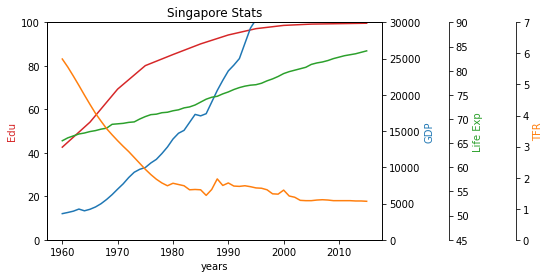

In [ ]:
import matplotlib.pyplot as plt

edu_parameter = "20-24-Primary_fin"
gdp_parameter = "gdppercapita_us_infla_adjust"
le_parameter  = "life_expectancy"
tfr_parameter = "children_per_woman"
# x axis values
years       = [y for y in range(1960,2016)]
x = years
# corresponding y axis values
edu_df = pd.read_csv(datasets_path[edu_parameter])
gdp_df = pd.read_csv(datasets_path[gdp_parameter])
le_df  = pd.read_csv(datasets_path[le_parameter])
tfr_df = pd.read_csv(datasets_path[tfr_parameter])

fig, ax = plt.subplots()
ax.set_xlabel('years')
ax.set_ylabel("Edu", color="tab:red")
ax.set_ylim([0,100])

twin1 = ax.twinx()
color = 'tab:blue'
twin1.set_ylabel('GDP', color=color)
twin1.set_ylim([0,30000])

twin2 = ax.twinx()
twin2.spines['right'].set_position(('axes', 1.2))
color = 'tab:green'
twin2.set_ylabel('Life Exp', color=color)
twin2.set_ylim([45,90])

twin3 = ax.twinx()
twin3.spines['right'].set_position(('axes', 1.4))
color = 'tab:orange'
twin3.set_ylabel('TFR', color=color)
twin3.set_ylim([0,7])

country = 'Singapore'
edu_df = edu_df[edu_df.Country.isin([country])]
gdp_df = gdp_df[gdp_df.Country.isin([country])]
le_df = le_df[le_df.Country.isin([country])]
tfr_df = tfr_df[tfr_df.Country.isin([country])]

y_edu = list(edu_df.values[0][1:])
y_gdp = list(gdp_df.values[0][1:])
y_le  = list(le_df.values[0][1:])
y_tfr = list(tfr_df.values[0][1:])

ax.plot(x,y_edu,label="Edu",color = "tab:red")
twin1.plot(x, y_gdp,label="GDP", color='tab:blue')
twin2.plot(x, y_le,label="Life Exp",color='tab:green')
twin3.plot(x, y_tfr,label="TFR",color='tab:orange')
# print(y_edu)
# print(y_gdp)
# print(y_le)
# print(y_tfr)
# print(scaler.fit(y_edu))
# print(scaler.fit(y_gdp))



# naming the x axis
# plt.xlabel('x - axis')
# # naming the y axis
# plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title(country + ' Stats')
 
# function to show the plot
plt.show()

# Building Model

In [ ]:
datasets = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            "best_life_expectancy"
        ]
find_common_countries(datasets)

['thailand', 'china', 'south korea', 'singapore']

### Life Expectancy

#### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'best_life_expectancy'

In [ ]:
datasets = [
            "best_20-24-Primary_OL",
            "best_children_per_woman",
            "best_gdppercapita_us_infla_adjust",
            # "best_life_expectancy"
            ]
get_countries_count(datasets)

Factor: best_20-24-Primary_OL            count: 22
Factor: best_children_per_woman          count: 19
Factor: best_gdppercapita_us_infla_adjust count: 15


In [ ]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [ ]:
input_df            = load_datasets_to_pd(datasets,OUTPUT,keys)
input_df.set_index(["country","year"], inplace=True)
input_df

loading best_20-24-Primary_OL
loading best_children_per_woman
loading best_gdppercapita_us_infla_adjust


,,best_20-24-Primary_OL,best_children_per_woman,best_gdppercapita_us_infla_adjust,o_best_life_expectancy
country,year,,,,
thailand,1960,89.20,6.15,581.0,60.9
south korea,1960,61.60,6.10,1030.0,59.1
china,1960,76.70,3.99,238.0,27.8
singapore,1960,68.50,5.82,3610.0,65.5
thailand,1961,87.98,6.15,594.0,61.8
...,...,...,...,...,...
singapore,2014,0.80,1.25,54700.0,83.8
thailand,2015,15.00,1.50,5840.0,78.2
south korea,2015,0.70,1.28,28700.0,82.6


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df

,,best_20-24-Primary_OL,best_children_per_woman,best_gdppercapita_us_infla_adjust
country,year,,,
thailand,1960,89.20,6.15,581.0
south korea,1960,61.60,6.10,1030.0
china,1960,76.70,3.99,238.0
singapore,1960,68.50,5.82,3610.0
thailand,1961,87.98,6.15,594.0
...,...,...,...,...
singapore,2014,0.80,1.25,54700.0
thailand,2015,15.00,1.50,5840.0
south korea,2015,0.70,1.28,28700.0


In [ ]:
output_df

,,o_best_life_expectancy
country,year,
thailand,1960,60.9
south korea,1960,59.1
china,1960,27.8
singapore,1960,65.5
thailand,1961,61.8
...,...,...
singapore,2014,83.8
thailand,2015,78.2
south korea,2015,82.6


In [ ]:
input_df.isna().sum()

best_20-24-Primary_OL                0
best_children_per_woman              0
best_gdppercapita_us_infla_adjust    0
dtype: int64

In [ ]:
input_df.shape

(224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmprr8a8s2d as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.093794
Training model
Model trained in 0:00:00.077934
Compiling model
1/1 [==============================] - 0s 123ms/step - loss: 0.0000e+00 - mse: 1.9314
BEST_LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 1.931431770324707}

MSE: 1.931431770324707
RMSE: 1.3897596088261837



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_20-24-Primary_OL
	best_children_per_woman
	best_gdppercapita_us_infla_adjust

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  5.464371 ################
    2.             "best_20-24-Primary_OL"  3.164541 ########
    3. "best_gdppercapita_us_infla_adjust"  1.350730 #
    4.           "best_children_per_woman"  0.844360 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 172.000000 ################
    2. "best_gdppercapita_us_infla_adjust" 75.000000 ##
    3.             "best_20-24-Primary_OL" 53.000000 

Variable Importance: NUM_NODES:
    1. "bes

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpyj6b7ac5 as temporary training directory
Starting reading the dataset
1/7 [===>..........................] - ETA: 0s
Dataset read in 0:00:00.200345
Training model
Model trained in 0:00:03.003214
Compiling model
7/7 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - mse: 0.0018
LIFE_EXPECTANCY
{'loss': 0.0, 'mse': 0.001753112766891718}

MSE: 0.001753112766891718
RMSE: 0.041870189477619016



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	20_yrs_old_gdppercapita_us_infla_adjust
	50__dropout_20-24-Primary_OL_comp
	children_per_woman
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  4.801453 ################
    2.       "50__dropout_20-24-Primary_OL_comp"  4.705225 ###############
    3.            "gdppercapita_us_infla_adjust"  4.624007 ###############
    4. "20_yrs_old_gdppercapita_us_infla_adjust"  4.570559 ##############


### TFR

#### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'children_per_woman'

In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            "co2_emissions_percapita",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("children_per_woman",n = 20),
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL",
            "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: life_expectancy                  count: 195
Factor: co2_emissions_percapita          count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: population                       count: 197
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202
Factor: 20-24_female-Lower_Secondary_OL  count: 202


In [ ]:
# creating a list of all countries & years
countries = ['china', 'singapore', 'south korea', 'thailand']
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)
input_df

loading life_expectancy
loading co2_emissions_percapita
loading gini_index
loading gdppercapita_us_infla_adjust
loading 20-24-In_Primary_OL
loading 20-24-Primary_OL
loading population
loading 20-24_female-In_Primary_OL
loading 20-24_female-Primary_OL
loading 20-24_female-Lower_Secondary_OL


,,life_expectancy,co2_emissions_percapita,gini_index,gdppercapita_us_infla_adjust,20-24-In_Primary_OL,20-24-Primary_OL,population,20-24_female-In_Primary_OL,20-24_female-Primary_OL,20-24_female-Lower_Secondary_OL,o_children_per_woman
country,year,,,,,,,,,,,
china,1960,27.8,1.180,25.3,238.0,41.40,76.70,6.600000e+08,53.10,85.30,98.70,3.99
singapore,1960,65.5,0.853,45.6,3610.0,57.40,68.50,1.630000e+06,69.30,78.10,95.00,5.82
south korea,1960,59.1,0.495,31.5,1030.0,24.00,61.60,2.530000e+07,36.50,78.20,92.60,6.10
thailand,1960,60.9,0.136,41.5,581.0,16.10,89.20,2.740000e+07,18.80,93.20,99.00,6.15
china,1961,40.8,0.822,25.1,175.0,39.28,75.18,6.710000e+08,50.64,83.88,98.44,3.28
...,...,...,...,...,...,...,...,...,...,...,...,...
thailand,2014,78.1,4.070,37.2,5690.0,3.16,15.74,6.840000e+07,2.96,13.04,30.68,1.51
china,2015,76.8,6.910,39.4,8070.0,1.50,5.10,1.410000e+09,1.80,5.70,46.50,1.62
singapore,2015,84.1,11.000,40.9,55600.0,0.40,0.70,5.590000e+06,0.50,0.70,4.00,1.24


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df

,,best_20-24-Primary_OL,best_gdppercapita_us_infla_adjust,best_life_expectancy
country,year,,,
thailand,1960,89.20,581.0,60.9
china,1960,76.70,238.0,27.8
south korea,1960,61.60,1030.0,59.1
singapore,1960,68.50,3610.0,65.5
thailand,1961,87.98,594.0,61.8
...,...,...,...,...
singapore,2014,0.80,54700.0,83.8
thailand,2015,15.00,5840.0,78.2
china,2015,5.10,8070.0,76.8


In [ ]:
output_df

,,o_best_children_per_woman
country,year,
thailand,1960,6.15
china,1960,3.99
south korea,1960,6.10
singapore,1960,5.82
thailand,1961,6.15
...,...,...
singapore,2014,1.25
thailand,2015,1.50
china,2015,1.62


In [ ]:
input_df.isna().sum()

best_20-24-Primary_OL                0
best_gdppercapita_us_infla_adjust    0
best_life_expectancy                 0
dtype: int64

In [ ]:
input_df.shape

(224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
# model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmp4h_ts3i9 as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.309265
Training model
Model trained in 0:00:00.248597
Compiling model
1/1 [==============================] - 1s 644ms/step


Evaluation(num_examples=224, accuracy=None, loss=None, rmse=0.31505496438320735, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (10):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Lower_Secondary_OL
	20-24_female-Primary_OL
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                         "__LABEL"  6.282871 ################
    2.                      "gini_index"  5.629707 #############
    3.      "20-24_female-In_Primary_OL"  5.445291 #############
    4.    "gdppercapita_us_infla_adjust"  5.407633 #############
    5.             "20-24-In_Primary_OL"  5.288400 ############
    6.                      "popul

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
# print()
model.make_inspector().evaluation()

Use /tmp/tmp7k4o4wub as temporary training directory
Starting reading the dataset
1/5 [=====>........................] - ETA: 0s
Dataset read in 0:00:00.233803
Training model
Model trained in 0:00:04.241121
Compiling model
5/5 [==============================] - 5s 1s/step


Evaluation(num_examples=None, accuracy=None, loss=0.21455296874046326, rmse=0.21455296874046326, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (11):
	20-24-Higher_Secondary_fin
	20-24-Lower_Secondary_fin
	20-24-Primary_fin
	20-24-female_Higher_Secondary_fin
	20-24-female_Lower_Secondary_fin
	20-24-female_Primary_fin
	co2_emissions_percapita
	gdppercapita_us_infla_adjust
	gini_index
	life_expectancy
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  4.727437 ################
    2.  "20-24-female_Lower_Secondary_fin"  4.186347 ##########
    3.        "20-24-Higher_Secondary_fin"  4.123877 #########
    4.         "20-24-Lower_Secondary_fin"  4.111740 #########
    5.                 "20-24-Primary_fi

### Primary Education

#### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Primary_OL'

In [ ]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            # "gini_index",
            # "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("infant_mortality",n = 20),
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 5),
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: 20_yrs_old_infant_mortality      count: 266
Factor: 10_yrs_old_gini_index            count: 195
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 5_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
countries = ['china', 'singapore', 'south korea', 'thailand']
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)
input_df

loading 20_yrs_old_infant_mortality
loading 10_yrs_old_gini_index
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading 5_yrs_old_gdppercapita_us_infla_adjust
loading gdppercapita_us_infla_adjust
loading population


,,20_yrs_old_infant_mortality,10_yrs_old_gini_index,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,5_yrs_old_gdppercapita_us_infla_adjust,gdppercapita_us_infla_adjust,population,o_20-24-Primary_OL
country,year,,,,,,,,
china,1980,NaN,23.3,309.00,3.99,337.0,431.0,1.000000e+09,38.00
singapore,1980,35.4,37.5,47.70,5.82,9970.0,13900.0,2.410000e+06,27.00
south korea,1980,79.7,34.1,112.00,6.10,2910.0,4060.0,3.800000e+07,13.00
thailand,1980,101.3,43.2,146.00,6.15,1090.0,1430.0,4.740000e+07,67.90
china,1981,NaN,23.3,262.00,3.28,327.0,447.0,1.010000e+09,35.84
...,...,...,...,...,...,...,...,...,...
thailand,2014,24.9,42.1,29.80,1.91,4830.0,5690.0,6.840000e+07,15.74
china,2015,37.7,41.1,47.40,1.64,5650.0,8070.0,1.410000e+09,5.10
singapore,2015,4.0,42.2,5.04,1.67,48700.0,55600.0,5.590000e+06,0.70


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df

,,gini_index,gdppercapita_us_infla_adjust,20_yrs_old_infant_mortality,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,5_yrs_old_gdppercapita_us_infla_adjust,population
country,year,,,,,,,
china,1960,25.3,238.0,NaN,NaN,NaN,NaN,6.600000e+08
singapore,1960,45.6,3610.0,NaN,NaN,NaN,NaN,1.630000e+06
south korea,1960,31.5,1030.0,NaN,NaN,NaN,NaN,2.530000e+07
thailand,1960,41.5,581.0,NaN,NaN,NaN,NaN,2.740000e+07
china,1961,25.1,175.0,NaN,NaN,NaN,NaN,6.710000e+08
...,...,...,...,...,...,...,...,...
thailand,2014,37.2,5690.0,24.9,29.80,1.91,4830.0,6.840000e+07
china,2015,39.4,8070.0,37.7,47.40,1.64,5650.0,1.410000e+09
singapore,2015,40.9,55600.0,4.0,5.04,1.67,48700.0,5.590000e+06


In [ ]:
output_df

,,o_20-24-Primary_OL
country,year,
china,1980,38.00
singapore,1980,27.00
south korea,1980,13.00
thailand,1980,67.90
china,1981,35.84
...,...,...
thailand,2014,15.74
china,2015,5.10
singapore,2015,0.70


In [ ]:
input_df.isna().sum()

best_children_per_woman              0
best_gdppercapita_us_infla_adjust    0
best_life_expectancy                 0
dtype: int64

In [ ]:
input_df.shape

(224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# # Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
# model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpxey3t__a as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:05.921482
Training model
Model trained in 0:00:00.078556
Compiling model
1/1 [==============================] - 6s 6s/step


Evaluation(num_examples=144, accuracy=None, loss=None, rmse=2.405375140647811, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (7):
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_infant_mortality
	5_yrs_old_gdppercapita_us_infla_adjust
	gdppercapita_us_infla_adjust
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                "__LABEL"  5.576468 ################
    2.            "20_yrs_old_infant_mortality"  4.628847 ############
    3.             "20_yrs_old_child_mortality"  4.541669 ############
    4.          "20_yrs_old_children_per_woman"  4.378492 ###########
    5. "5_yrs_old_gdppercapita_us_infla_adjust"  3.524350 ########
    6.                             "pop

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpcgozjfv4 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.135211
Training model
Model trained in 0:00:00.339765
Compiling model
1/1 [==============================] - 0s 495ms/step


1/1 [==============================] - 0s 155ms/step - loss: 0.0000e+00 - mse: 2.8986
BEST_20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 2.898608446121216}

MSE: 2.898608446121216
RMSE: 1.702530013280593



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_children_per_woman
	best_gdppercapita_us_infla_adjust
	best_life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  3.981581 ################
    2.              "best_life_expectancy"  1.640411 #
    3. "best_gdppercapita_us_infla_adjust"  1.521010 
    4.           "best_children_per_woman"  1.402811 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 141.000000 ################
    2.              "best_life_expectancy" 76.000000 ##
    3. "best_gdppercapita_us_infla_adjust" 63.000000 

Variable Importance: NUM_NODES:
    

### Primary Education

#### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = '20-24-Primary_OL'

In [ ]:
datasets = [
            # "infant_mortality",
            # "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            # "gini_index",
            # "gdppercapita_us_infla_adjust",
            create_n_yrs_old_csv("infant_mortality",n = 20),
            create_n_yrs_old_csv("gini_index",n = 10),
            # create_n_yrs_old_csv("co2_emissions_percapita",n = 10),
            # create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 5),
            "gdppercapita_us_infla_adjust",
            # create_n_yrs_old_csv("20-24-Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-Higher_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Primary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Lower_Secondary_fin",n = 20),
            # create_n_yrs_old_csv("20-24-female_Higher_Secondary_fin",n = 20),
            # "gdp_growth",
            
            # create_n_dropout_csv("20-24-Primary_OL_comp",50,95),
            # rate_of_dropout("20-24-Primary_OL",5),
            # "20-24-In_Primary_OL",
            # "20-24-Primary_OL",
            # "20-24-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: 20_yrs_old_infant_mortality      count: 266
Factor: 10_yrs_old_gini_index            count: 195
Factor: 20_yrs_old_child_mortality       count: 197
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 5_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
countries = ['china', 'singapore', 'south korea', 'thailand']
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
input_df.set_index(["country","year"], inplace=True)
input_df

loading 20_yrs_old_infant_mortality
loading 10_yrs_old_gini_index
loading 20_yrs_old_child_mortality
loading 20_yrs_old_children_per_woman
loading 5_yrs_old_gdppercapita_us_infla_adjust
loading gdppercapita_us_infla_adjust
loading population


,,20_yrs_old_infant_mortality,10_yrs_old_gini_index,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,5_yrs_old_gdppercapita_us_infla_adjust,gdppercapita_us_infla_adjust,population,o_20-24-Primary_OL
country,year,,,,,,,,
china,1980,NaN,23.3,309.00,3.99,337.0,431.0,1.000000e+09,38.00
singapore,1980,35.4,37.5,47.70,5.82,9970.0,13900.0,2.410000e+06,27.00
south korea,1980,79.7,34.1,112.00,6.10,2910.0,4060.0,3.800000e+07,13.00
thailand,1980,101.3,43.2,146.00,6.15,1090.0,1430.0,4.740000e+07,67.90
china,1981,NaN,23.3,262.00,3.28,327.0,447.0,1.010000e+09,35.84
...,...,...,...,...,...,...,...,...,...
thailand,2014,24.9,42.1,29.80,1.91,4830.0,5690.0,6.840000e+07,15.74
china,2015,37.7,41.1,47.40,1.64,5650.0,8070.0,1.410000e+09,5.10
singapore,2015,4.0,42.2,5.04,1.67,48700.0,55600.0,5.590000e+06,0.70


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df

,,gini_index,gdppercapita_us_infla_adjust,20_yrs_old_infant_mortality,20_yrs_old_child_mortality,20_yrs_old_children_per_woman,5_yrs_old_gdppercapita_us_infla_adjust,population
country,year,,,,,,,
china,1960,25.3,238.0,NaN,NaN,NaN,NaN,6.600000e+08
singapore,1960,45.6,3610.0,NaN,NaN,NaN,NaN,1.630000e+06
south korea,1960,31.5,1030.0,NaN,NaN,NaN,NaN,2.530000e+07
thailand,1960,41.5,581.0,NaN,NaN,NaN,NaN,2.740000e+07
china,1961,25.1,175.0,NaN,NaN,NaN,NaN,6.710000e+08
...,...,...,...,...,...,...,...,...
thailand,2014,37.2,5690.0,24.9,29.80,1.91,4830.0,6.840000e+07
china,2015,39.4,8070.0,37.7,47.40,1.64,5650.0,1.410000e+09
singapore,2015,40.9,55600.0,4.0,5.04,1.67,48700.0,5.590000e+06


In [ ]:
output_df

,,o_20-24-Primary_OL
country,year,
china,1980,38.00
singapore,1980,27.00
south korea,1980,13.00
thailand,1980,67.90
china,1981,35.84
...,...,...
thailand,2014,15.74
china,2015,5.10
singapore,2015,0.70


In [ ]:
input_df.isna().sum()

best_children_per_woman              0
best_gdppercapita_us_infla_adjust    0
best_life_expectancy                 0
dtype: int64

In [ ]:
input_df.shape

(224, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# # Convert it to a TensorFlow dataset
# test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# # Evaluate the model
# model.compile(metrics=["mse"])
# # Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpxey3t__a as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:05.921482
Training model
Model trained in 0:00:00.078556
Compiling model
1/1 [==============================] - 6s 6s/step


Evaluation(num_examples=144, accuracy=None, loss=None, rmse=2.405375140647811, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (7):
	10_yrs_old_gini_index
	20_yrs_old_child_mortality
	20_yrs_old_children_per_woman
	20_yrs_old_infant_mortality
	5_yrs_old_gdppercapita_us_infla_adjust
	gdppercapita_us_infla_adjust
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                "__LABEL"  5.576468 ################
    2.            "20_yrs_old_infant_mortality"  4.628847 ############
    3.             "20_yrs_old_child_mortality"  4.541669 ############
    4.          "20_yrs_old_children_per_woman"  4.378492 ###########
    5. "5_yrs_old_gdppercapita_us_infla_adjust"  3.524350 ########
    6.                             "pop

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpcgozjfv4 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.135211
Training model
Model trained in 0:00:00.339765
Compiling model
1/1 [==============================] - 0s 495ms/step


1/1 [==============================] - 0s 155ms/step - loss: 0.0000e+00 - mse: 2.8986
BEST_20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 2.898608446121216}

MSE: 2.898608446121216
RMSE: 1.702530013280593



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	best_children_per_woman
	best_gdppercapita_us_infla_adjust
	best_life_expectancy

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                           "__LABEL"  3.981581 ################
    2.              "best_life_expectancy"  1.640411 #
    3. "best_gdppercapita_us_infla_adjust"  1.521010 
    4.           "best_children_per_woman"  1.402811 

Variable Importance: NUM_AS_ROOT:
    1.           "best_children_per_woman" 141.000000 ################
    2.              "best_life_expectancy" 76.000000 ##
    3. "best_gdppercapita_us_infla_adjust" 63.000000 

Variable Importance: NUM_NODES:
    

### GDP

#### Preparing the Data

In [ ]:
PREDICT_FUTURE  = 0
OUTPUT          = 'gdppercapita_us_infla_adjust'

In [ ]:
datasets = [
            # "infant_mortality",
            "life_expectancy",
            # "child_mortality",
            # "children_per_woman",
            # "co2_emissions_percapita",
            "gini_index",
            create_n_yrs_old_csv("infant_mortality",n = 20),
            create_n_yrs_old_csv("life_expectancy",n = 20),
            create_n_yrs_old_csv("child_mortality",n = 20),
            create_n_yrs_old_csv("children_per_woman",n = 20),
            create_n_yrs_old_csv("gdppercapita_us_infla_adjust",n = 20),
            # create_n_yrs_old_csv("20-24-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24-Primary_OL",n = 20),
            create_n_yrs_old_csv("20-24-Lower_Secondary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-In_Primary_OL",n = 20),
            # create_n_yrs_old_csv("20-24_female-Primary_OL",n = 20),
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL",
            "20-24_female-Lower_Secondary_OL",
            "population",
            # "20-24_female-In_Primary_OL",
            # "20-24_female-Primary_OL",
            # "20-24_female-Lower_Secondary_OL",
            ]
get_countries_count(datasets)

Factor: gini_index                       count: 195
Factor: 20_yrs_old_infant_mortality      count: 266
Factor: 20_yrs_old_children_per_woman    count: 202
Factor: 20_yrs_old_gdppercapita_us_infla_adjust count: 207
Factor: 20_yrs_old_20-24-Lower_Secondary_OL count: 202
Factor: population                       count: 197


In [ ]:
# creating a list of all countries & years
# countries = ['china', 'singapore', 'south korea', 'thailand']
countries = ['south korea']
years     = [y for y in range(1980,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [ ]:
countries.sort()
countries

['china', 'singapore', 'south korea', 'thailand']

In [ ]:
input_df            = load_datasets_to_pd(datasets = datasets, keys = keys, o_dataset = OUTPUT)
# input_df.set_index(["country","year"], inplace=True)
input_df.drop(labels=["country","year"], axis = 1, inplace=True)

loading gini_index
loading 20_yrs_old_infant_mortality
loading 20_yrs_old_children_per_woman
loading 20_yrs_old_gdppercapita_us_infla_adjust
loading 20_yrs_old_20-24-Lower_Secondary_OL
loading population


,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-Lower_Secondary_OL,population,o_gdppercapita_us_infla_adjust
country,year,,,,,,,
china,1980,24.5,NaN,3.99,238.0,97.1,1.000000e+09,431.0
singapore,1980,33.0,35.4,5.82,3610.0,90.0,2.410000e+06,13900.0
south korea,1980,39.0,79.7,6.10,1030.0,83.3,3.800000e+07,4060.0
thailand,1980,44.8,101.3,6.15,581.0,98.4,4.740000e+07,1430.0
china,1981,24.8,NaN,3.28,175.0,96.7,1.010000e+09,447.0
...,...,...,...,...,...,...,...,...
thailand,2014,37.2,24.9,1.91,3360.0,66.6,6.840000e+07,5690.0
china,2015,39.4,37.7,1.64,1520.0,74.6,1.410000e+09,8070.0
singapore,2015,40.9,4.0,1.67,30400.0,14.7,5.590000e+06,55600.0


In [ ]:
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [ ]:
input_df

,,gini_index,20_yrs_old_infant_mortality,20_yrs_old_children_per_woman,20_yrs_old_gdppercapita_us_infla_adjust,20_yrs_old_20-24-Lower_Secondary_OL,population
country,year,,,,,,
china,1980,24.5,NaN,3.99,238.0,97.1,1.000000e+09
singapore,1980,33.0,35.4,5.82,3610.0,90.0,2.410000e+06
south korea,1980,39.0,79.7,6.10,1030.0,83.3,3.800000e+07
thailand,1980,44.8,101.3,6.15,581.0,98.4,4.740000e+07
china,1981,24.8,NaN,3.28,175.0,96.7,1.010000e+09
...,...,...,...,...,...,...,...
thailand,2014,37.2,24.9,1.91,3360.0,66.6,6.840000e+07
china,2015,39.4,37.7,1.64,1520.0,74.6,1.410000e+09
singapore,2015,40.9,4.0,1.67,30400.0,14.7,5.590000e+06


In [ ]:
output_df

,,o_gdppercapita_us_infla_adjust
country,year,
china,1980,431.0
singapore,1980,13900.0
south korea,1980,4060.0
thailand,1980,1430.0
china,1981,447.0
...,...,...
thailand,2014,5690.0
china,2015,8070.0
singapore,2015,55600.0


In [ ]:
input_df.isna().sum()

gini_index                                 0
20_yrs_old_infant_mortality                9
20_yrs_old_children_per_woman              0
20_yrs_old_gdppercapita_us_infla_adjust    0
20_yrs_old_20-24-Lower_Secondary_OL        0
population                                 0
dtype: int64

In [ ]:
input_df.shape

(144, 3)

#### RNN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.15, random_state=43)

#### Random Forest Model

In [ ]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(input_df,output_df), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
# evaluation = model.evaluate(test_ds, return_dict=True)
# print(OUTPUT.upper())
# print(evaluation)
# print()
# print(f"MSE: {evaluation['mse']}")
# print(f"RMSE: {math.sqrt(evaluation['mse'])}")
model.make_inspector().evaluation()

Use /tmp/tmpu85d9nfi as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.319288
Training model
Model trained in 0:00:00.164369
Compiling model
1/1 [==============================] - 1s 578ms/step


Evaluation(num_examples=144, accuracy=None, loss=None, rmse=1719.1420060416235, ndcg=None, aucs=None)

In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300
model.summary()

Model: "random_forest_model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  5.155842 ################
    2.           "20_yrs_old_children_per_woman"  4.435326 #############
    3.                              "gini_index"  4.030521 ###########
    4.                              "population"  3.412205 ########
    5.     "20_yrs_old_20-24-Lower_Secondary_OL"  2.946930 #######
    6.             "20_yrs_old_infant_mortality"  2.567235 #####
 

#### Gradient Tree

In [ ]:
# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

Use /tmp/tmpqxxs3yem as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.173170
Training model
Model trained in 0:00:00.158935
Compiling model
1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 185ms/step - loss: 0.0000e+00 - mse: 939368.2500
GDPPERCAPITA_US_INFLA_ADJUST
{'loss': 0.0, 'mse': 939368.25}

MSE: 939368.25
RMSE: 969.2101165382045



In [ ]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	20_yrs_old_20-24-Lower_Secondary_OL
	20_yrs_old_children_per_woman
	20_yrs_old_gdppercapita_us_infla_adjust
	20_yrs_old_infant_mortality
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                                 "__LABEL"  3.851117 ################
    2.                              "gini_index"  3.110536 ##########
    3.           "20_yrs_old_children_per_woman"  3.066411 ##########
    4.             "20_yrs_old_infant_mortality"  3.044838 ##########
    5.                              "population"  2.797885 ########
    6.     "20_yrs_old_20-24-Lower_Secondary_OL" 

# Save the summary

In [ ]:
#@markdown What changes you made to datasets & why ?


approach = 'for all countries'  #@param {type: "string"}


In [ ]:
inspector = model.make_inspector()

In [ ]:
model_name = inspector.model_type()
num_trees  = inspector.num_trees()
objective  = inspector.objective()
eval = inspector.evaluation()

In [ ]:

input_features_list = inspector.features()
input_features = ""
for i in range(len(input_features_list)):
  input_features += str(i+1)+ "  "
  input_features += input_features_list[i][0] + "\n"

In [ ]:
variable_imp = []
variable_imp.append(extract_variable_imp(variable = 'MEAN_MIN_DEPTH'))
variable_imp.append(extract_variable_imp(variable = 'SUM_SCORE'))


In [ ]:
#@ Analysis
#@markdown Observations made from the output ?


anaylsis = ''  #@param {type: "string"}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('/content/drive/My Drive/education-impact/final-doc.txt', 'a') as f:
  f.write("Model Trained : " + model_name+ "\n")
  f.write("Predicting : " + OUTPUT + "\n")
  f.write("Approach : " + approach + "\n")
  f.write("Num Examples: " + str(eval.num_examples) + "\n\n")
  f.write("Input Features\n")
  f.write(input_features+"\n\n")
  f.write("Model Performance\n")
  f.write("RMSE Score : "  + str(eval.rmse)+ "\n\n")
  for v in variable_imp:
    f.write(v + "\n\n")
  f.write("Analysis : " + anaylsis + "\n")
  f.write("\n\n\n")

  

# Models to try
 - RandomForestModel
 - GradientBoostedTreesModel
 - CartModel
 - DistributedGradientBoostedTreesModel

 - KNN Regression
 - Support Vector Regression
 - Locally Weighted Scatterplot Smoothing
 - Multivariate Adaptive Regression Splines
  

In [ ]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]